---
# Pilot SRF

This notebook describes the first attempt with the hole-response experiment. The pipeline starts of after [call_lsprep](https://github.com/gjheij/linescanning/blob/main/bin/call_lsprep), which creates an `h5`-file with all relevant dataframes

In [1]:
from linescanning import (
    utils,
    dataset,
    fitting,
    plotting,
    glm,
    pycortex
)
import holeresponse as hr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
opj = os.path.join

## Data loader

In [2]:
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
subject = "sub-006"
# ribbon = (357,366)

# get h5-file
sesID = 2
data_file = opj(deriv, "lsprep", subject, f"{subject}_ses-{sesID}_desc-preproc_bold.h5")

# load in
obj_ = dataset.Dataset(
    data_file,
    verbose=True
)

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-006/sub-006_ses-2_desc-preproc_bold.h5


 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses

DATASET: created


In [3]:
df_onsets = obj_.fetch_onsets()
df_func = obj_.fetch_fmri(dtype="raw")
df_filt = obj_.fetch_fmri(dtype="psc")
df_func

Fetching dataframe from attribute 'df_func_raw'
Fetching dataframe from attribute 'df_func_psc'


vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
006     1   0.000    1.187746  1.625713  1.896854  1.767264  1.862083   
            0.105    1.131528  1.741126  1.923028  1.666482  2.163349   
            0.210    1.239784  1.777164  2.008711  1.566041  1.727267   
            0.315    1.374160  1.721401  1.880311  1.671320  1.942962   
            0.420    1.304478  1.772128  1.682777  1.503582  1.697549   
...                       ...       ...       ...       ...       ...   
        6   293.475  1.572103  2.063497  1.926013  2.421204  2.872102   
            293.580  1.356742  1.810083  1.604814  1.813244  2.345825   
            293.685  1.293958  1.913154  1.674224  2.553254  2.274072   
            293.790  1.322178  1.734628  1.867182  2.173172  2.330895   
            293.895  1.479201  1.857961  1.502480  2.282692  2.356452   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
006     1   0.000    1.779010  1.441361  1.314041  1.210329  1.032477  ...   
            0.105    1.601730  1.544117  1.451756  1.049331  0.823748  ...   
            0.210    1.771210  1.611693  1.358335  1.138650  1.175937  ...   
            0.315    1.677038  1.394304  1.397901  0.991988  0.989389  ...   
            0.420    1.717786  1.447369  1.407070  0.993784  1.055302  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   293.475  2.118977  2.033400  2.105016  2.405550  1.605257  ...   
            293.580  2.368618  2.169369  1.939756  2.251674  1.702598  ...   
            293.685  2.371468  2.075633  2.444543  2.297869  1.649541  ...   
            293.790  2.171551  1.901776  1.790658  2.092686  1.712919  ...   
            293.895  2.394973  1.987733  1.906086  2.115202  1.601433  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
006     1   0.000    0.575715  0.504040  0.497780  0.392575  0.550286   
            0.105    0.626814  0.436176  0.417052  0.375945  0.417043   
            0.210    0.518375  0.459233  0.200931  0.596077  0.599491   
            0.315    0.483595  0.287115  0.464018  0.715299  0.515800   
            0.420    0.584603  0.396400  0.265776  0.437018  0.436413   
...                       ...       ...       ...       ...       ...   
        6   293.475  1.084440  1.224852  0.422279  0.737705  0.790969   
            293.580  1.388724  0.407879  0.683293  0.800115  0.882033   
            293.685  0.988323  0.474138  0.479727  0.749913  0.585693   
            293.790  0.845384  0.479970  0.518751  0.760995  0.689903   
            293.895  0.757264  0.446394  0.350513  0.391201  0.801325   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
006     1   0.000    0.395784  0.705765  0.623694  0.297773  0.397859  
            0.105    0.375413  0.517482  0.522148  0.561144  0.537021  
            0.210    0.483804  0.571110  0.538104  0.482507  0.524017  
            0.315    0.405758  0.423091  0.440058  0.557960  0.393707  
            0.420    0.413981  0.391114  0.722844  0.427498  0.477851  
...                       ...       ...       ...       ...       ...  
        6   293.475  0.913083  0.512066  0.835897  1.056031  0.644414  
            293.580  0.562264  0.765289  0.599065  0.918076  0.710895  
            293.685  0.729110  0.383155  0.467951  0.467616  0.985308  
            293.790  0.814051  0.571392  0.679421  0.705519  0.641597  
            293.895  0.517312  0.314509  0.623697  0.482074  0.810556  

[16800 rows x 720 columns]

In [4]:
fig_dir = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/{subject}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir, exist_ok=True)

In [5]:
run_ids = obj_.get_runs(df_func)
# ribbon = (360,368)
# df_rib = utils.select_from_df(df_func, expression="ribbon", indices=ribbon)

try:
    srfa = utils.select_from_df(df_func, expression="task = SRFa")
except:
    srfa = df_func.copy()

In [6]:
# average across runs within tasks
try:
    df_avg = df_func.groupby(["subject","task","t"]).mean()
except:
    df_avg = df_func.groupby(["subject","t"]).mean()
df_avg

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject t                                                                     
006     0.000    1.277223  1.465869  1.570049  1.682104  1.629262  1.618817   
        0.105    1.193879  1.523256  1.561769  1.589843  1.770291  1.636402   
        0.210    1.144646  1.526011  1.519754  1.556692  1.659497  1.580801   
        0.315    1.242765  1.609490  1.488814  1.687264  1.649835  1.555923   
        0.420    1.203243  1.534957  1.457184  1.571350  1.730337  1.619760   
...                   ...       ...       ...       ...       ...       ...   
        293.475  1.329413  1.577371  1.659321  1.663643  1.708556  1.491967   
        293.580  1.288552  1.473844  1.538531  1.651997  1.614535  1.558958   
        293.685  1.332051  1.581056  1.624972  1.810750  1.565812  1.502851   
        293.790  1.213908  1.524907  1.624260  1.718235  1.579086  1.537551   
        293.895  1.341926  1.482622  1.527079  1.712662  1.580920  1.518493   

                    vox 6     vox 7     vox 8     vox 9  ...   vox 710  \
subject t                                                ...             
006     0.000    1.536861  1.451704  1.572223  1.544446  ...  0.515031   
        0.105    1.532767  1.560415  1.417811  1.406229  ...  0.503322   
        0.210    1.587773  1.465816  1.508635  1.530624  ...  0.523079   
        0.315    1.473296  1.585135  1.536111  1.513234  ...  0.533211   
        0.420    1.427748  1.548180  1.499929  1.492337  ...  0.563047   
...                   ...       ...       ...       ...  ...       ...   
        293.475  1.517096  1.456485  1.590577  1.494594  ...  0.520687   
        293.580  1.592913  1.491631  1.572081  1.438914  ...  0.645810   
        293.685  1.473687  1.533086  1.597776  1.453081  ...  0.561293   
        293.790  1.414218  1.416891  1.592737  1.475673  ...  0.503519   
        293.895  1.483790  1.558010  1.555102  1.446421  ...  0.458268   

                  vox 711   vox 712   vox 713   vox 714   vox 715   vox 716  \
subject t                                                                     
006     0.000    0.524454  0.497606  0.471443  0.538238  0.424672  0.543785   
        0.105    0.486013  0.508457  0.530139  0.452510  0.472332  0.502327   
        0.210    0.473769  0.371112  0.467563  0.439169  0.405484  0.468022   
        0.315    0.519929  0.564448  0.542293  0.513598  0.524272  0.502367   
        0.420    0.559283  0.449467  0.385681  0.420444  0.505461  0.507184   
...                   ...       ...       ...       ...       ...       ...   
        293.475  0.681328  0.428601  0.514861  0.514752  0.448880  0.432020   
        293.580  0.485221  0.522803  0.558960  0.514498  0.398909  0.568829   
        293.685  0.516174  0.407213  0.561502  0.459514  0.530649  0.468571   
        293.790  0.533372  0.502063  0.484050  0.541075  0.471094  0.429986   
        293.895  0.470213  0.416592  0.380247  0.500411  0.437685  0.445130   

                  vox 717   vox 718   vox 719  
subject t                                      
006     0.000    0.477818  0.464288  0.446409  
        0.105    0.384038  0.451225  0.514371  
        0.210    0.459230  0.536303  0.527514  
        0.315    0.501495  0.525986  0.494450  
        0.420    0.505006  0.430119  0.439310  
...                   ...       ...       ...  
        293.475  0.539801  0.519360  0.419571  
        293.580  0.558125  0.616273  0.448731  
        293.685  0.423565  0.464809  0.539781  
        293.790  0.440638  0.463736  0.431879  
        293.895  0.467044  0.479439  0.493492  

[2800 rows x 720 columns]

In [7]:
def index_to_column(df, index=None):

    # keep track of columns
    column_list = list(df.columns)

    # get unique values of index
    unique_values = np.unique(df[index].values)

    # loop through them and put them in columns
    df_pivot = []
    for val in unique_values:
        indexed_values = utils.select_from_df(df, expression=f"{index} = val").rename(columns={"average"})
        df_pivot.append(indexed_values)

    return pd.concat(df_pivot)

# index_to_column(df_corr, index="run")



In [8]:
# obj_.get_runs(df_corr)

In [9]:
# tmp2 = utils.select_from_df(df_corr, expression="run = 1")
# tmp2 = tmp2.rename(columns={"average": "run_1"})
# tmp2

In [10]:
# df_corr = pd.DataFrame(utils.select_from_df(df_filt, expression="ribbon", indices=ribbon).mean(axis=1), columns=["average"])
# df_corr

In [12]:
# select ribbon voxels
# ribbon = (346,359)
# ribbon = (360,369) # sub-001
# ribbon = (360,366)  # sub-002
# ribbon = (355,363) # sub-003
ribbon = (357,366) # sub-006
df_ribbon = utils.select_from_df(
    df_filt.groupby(["subject","t"]).mean(), 
    expression="ribbon", 
    indices=ribbon
)
df_ribbon

vox 357   vox 358   vox 359   vox 360   vox 361   vox 362  \
subject t                                                                     
006     0.000   -0.348059 -0.174502 -0.261333 -0.187846 -0.078641 -0.321503   
        0.105   -0.117662  0.010147  0.175145  0.097352  0.082867  0.367322   
        0.210    0.557093  0.370444  0.299833  0.297384  0.506386  0.087354   
        0.315    0.096745 -0.023221  0.131969  0.077520  0.082381  0.236375   
        0.420   -0.260572  0.004637  0.299712  0.098232  0.418100  0.122449   
...                   ...       ...       ...       ...       ...       ...   
        293.475 -0.848008 -0.716513 -0.784646 -0.865307 -0.464060 -0.636917   
        293.580 -0.905636 -0.909409 -0.639896 -0.737380 -0.717224 -0.745800   
        293.685 -0.416144 -0.397687  0.012478 -0.625729 -0.277660 -0.316608   
        293.790 -0.508284 -0.646399 -0.729261 -0.332272 -0.483532 -0.345284   
        293.895 -0.579765 -0.713156 -0.464185 -0.523065 -0.472182 -0.341128   

                  vox 363   vox 364   vox 365  
subject t                                      
006     0.000   -0.255746 -0.091667 -0.254022  
        0.105    0.007149  0.033410  0.115039  
        0.210    0.220918  0.503985  0.645987  
        0.315    0.373377  0.113096  0.180969  
        0.420    0.089076  0.395259  0.344503  
...                   ...       ...       ...  
        293.475 -0.318002 -0.275467 -0.323353  
        293.580 -0.508570 -0.567900 -0.484065  
        293.685 -0.071467 -0.302371 -0.448030  
        293.790 -0.401775 -0.143033 -0.206512  
        293.895 -0.451672 -0.191785 -0.288253  

[2800 rows x 9 columns]

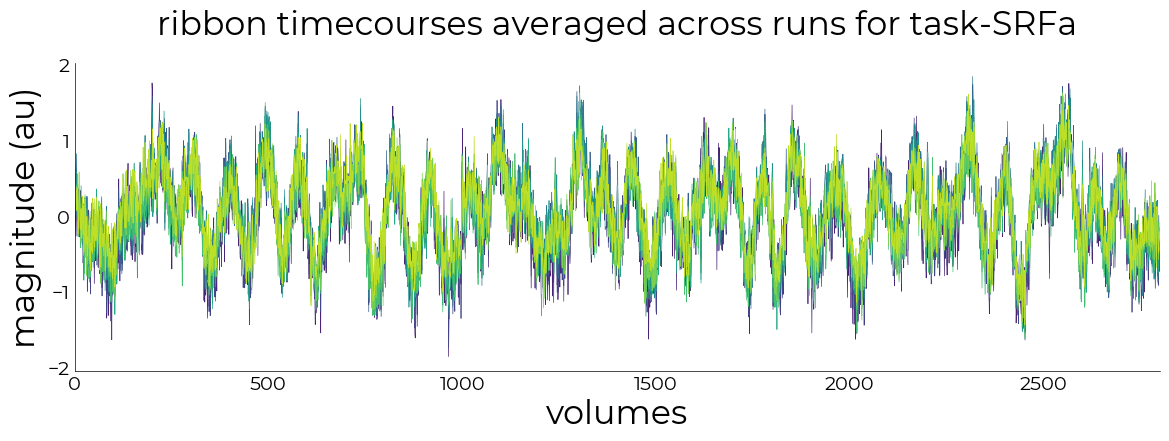

In [13]:
%matplotlib inline
# plot timecourses
try:
    task1_data = utils.select_from_df(df_ribbon, expression="task = SRFa")
except:
    task1_data = df_ribbon

plotting.LazyPlot(
    list(task1_data.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline="mean",
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

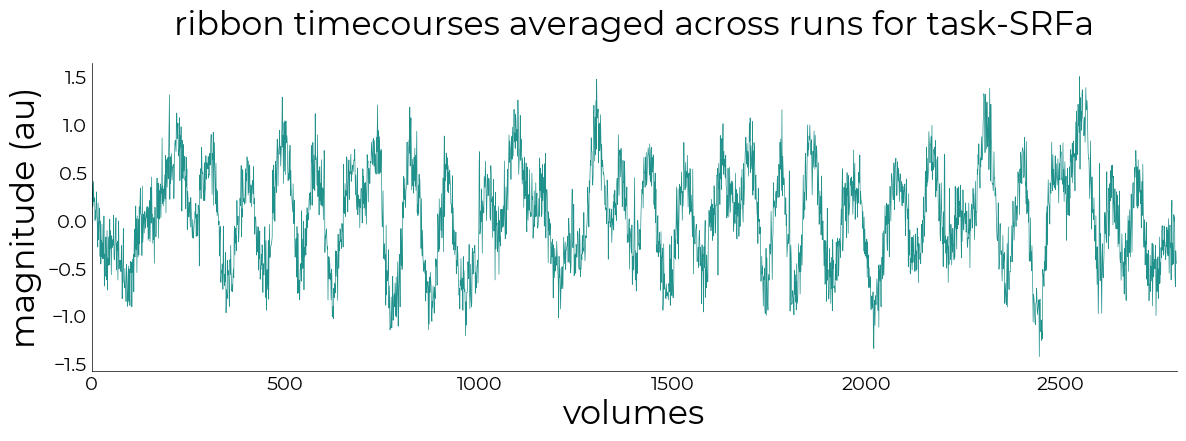

In [14]:
# select ribbon voxels
df_ribbon_avg = pd.DataFrame(df_ribbon.mean(axis=1), columns=["average"])
df_ribbon_avg

# plot timecourses
try:
    task1_avg = utils.select_from_df(df_ribbon_avg, expression="task = SRFa")
except:
    task1_avg = df_ribbon_avg.copy()

plotting.LazyPlot(
    list(task1_avg.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline=0,
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [15]:
task_ids = utils.get_ids(df_onsets)

if len(task_ids) > 0:
    # switch our task-ID for run-IDs so we can flop everything in nideconv
    renamed_func = []
    renamed_onsets = []

    task_onsets = utils.select_from_df(df_onsets, expression="event_type != response")
    for ix,task in enumerate(["SRFa","SRFb"]):
        
        # sort out func
        df = utils.select_from_df(df_ribbon_avg, expression=f"task = {task}").reset_index()
        df["run"] = ix+1
        df = df.drop("task", axis=1)
        renamed_func.append(df)

        # sort out onsets
        df = utils.select_from_df(task_onsets, expression=(f"task = {task}","&","run = 1")).reset_index()
        df["run"] = ix+1
        df = df.drop("task", axis=1)
        renamed_onsets.append(df)

    renamed_func = pd.concat(renamed_func).set_index(["subject","run","t"])
    renamed_onsets = pd.concat(renamed_onsets).set_index(["subject","run","event_type"])
else:
    renamed_func = df_ribbon_avg.copy()
    renamed_onsets = df_onsets.copy()

## t-stats from 3D-EPI

In [16]:
# # find cope files
# zstats = []
# for ii in range(2):
#     z_file = opj(
#         deriv,
#         "feat",
#         "level2",
#         f"{subject}_desc-level1.gfeat",
#         f"{subject}_ses-2_task-SRFi_space-fsnative_hemi-LR_desc-cope{ii+1}.npy"
#         )
    
#     if os.path.exists(z_file):
#         zstats.append(z_file)
#     else:
#         raise FileNotFoundError(f"Could not find file '{z_file}'")
# zstats

In [17]:
# # create objects
# z1_data = np.load(zstats[0])
# z2_data = np.load(zstats[1])

# z1_pos = np.zeros_like(z1_data)
# z1_pos[z1_data > 2.3] = z1_data[z1_data>2.3]

# z2_neg = np.zeros_like(z2_data)
# z2_neg_mask = np.zeros_like(z2_data)
# z2_neg[z2_data<-2.3] = z2_data[z2_data<-2.3]
# z2_neg_mask[z2_data<-2.3] = 1

# z1_pos_v = pycortex.Vertex2D_fix(
#     z1_pos,
#     subject=subject,
#     cmap="inferno",
#     vmin1=2.3,
#     vmax1=8
# )

# z2_neg_v = pycortex.Vertex2D_fix(
#     z2_neg,
#     subject=subject,
#     data2=z2_neg_mask,
#     cmap="cool",
#     vmin1=-8,
#     vmax1=-2.3
# )

# # target vertex
# target = 968 #11253
# target_data = np.zeros_like(z1_data)
# target_data[target] = 1
# target_v = pycortex.Vertex2D_fix(
#     target_data, 
#     subject=subject, 
#     cmap="magma")

# # beam image
# beam = opj(os.path.dirname(zstats[0]), f"{subject}_ses-2_task-SRFa_space-fsnative_hemi-LR_desc-beam.npy")
# beam_data = np.load(beam)
# beam_v = pycortex.Vertex2D_fix(
#     beam_data, 
#     subject=subject, 
#     cmap="magma")

In [18]:
# # read prf estimates
# prf_dir = opj(deriv, "prf", subject, "ses-1")
# pyc = pycortex.SavePycortexViews(
#     {
#         "act": z1_pos_v,
#         "neg": z2_neg_v,
#         "beam": beam_v,
#         "target": target_v
#     },
#     subject=subject,
#     radius=240,
#     azimuth=200,
#     altitude=118,
#     pivot=0,
#     # clicker="plot",
#     # transpose=True,
#     # prf_file=opj(prf_dir, f"{subject}_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl"),
#     # func_data=opj(prf_dir, f"{subject}_ses-1_task-2R_hemi-LR_desc-avg_bold.npy"),
#     # dm=opj(prf_dir, "design_task-2R.mat"),
#     rh=0,
#     verbose=False)

In [19]:
# pyc.save_all(
#     fig_dir=os.path.dirname(zstats[0]),
#     gallery=True,
#     add_cms=True,
#     n_cols=4,
#     cb=[200,1000,350,1500]
# )

## GLM

In [20]:
from linescanning import preproc
try:
    hp_data = utils.select_from_df(renamed_func, expression="run = 1")
except:
    hp_data = renamed_func.copy()

hp_lp_data = preproc.lowpass_savgol(
    hp_data.squeeze(),
    window_length=41,
    polyorder=3
)

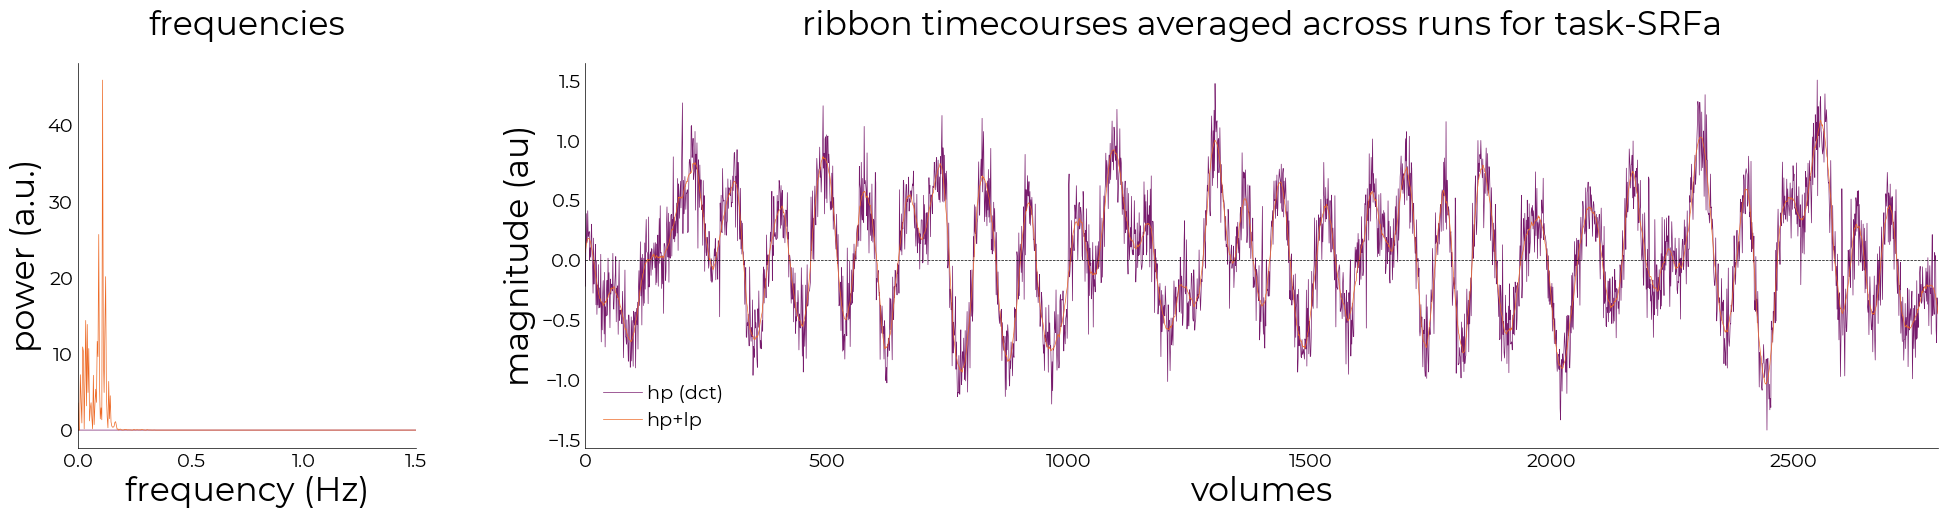

In [21]:

# collect power spectra
freqs = []
tcs = [hp_data,hp_lp_data]
lbls = ["hp (dct)", "hp+lp"]
for tc in tcs:

    # freq
    tc_freq = preproc.get_freq(tc, TR=0.105, spectrum_type='fft')

    # append
    freqs.append(tc_freq)         

# create figure
fig,axs = plt.subplots(ncols=2, figsize=(24,5), gridspec_kw={"width_ratios": [0.2,0.8]})
colors = ["#cccccc","r"]
lws = 0.5
fs = 24

plotting.LazyPlot(
    [freqs[ii][1] for ii in range(len(tcs))],
    xx=freqs[0][0],
    x_label="frequency (Hz)",
    y_label="power (a.u.)",
    title="frequencies",
    axs=axs[0],
    x_lim=[0,1.5],
    line_width=lws,
    font_size=fs,
    # color=colors,
    cmap="inferno",
    # y_lim=[0,10]
    ) 


# plot timecourses
plotting.LazyPlot(
    tcs,
    axs=axs[1],
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=fs,
    # add_hline=0,
    line_width=lws,
    # color=colors,
    cmap="inferno",
    labels=lbls,
    add_hline=0,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [22]:
try:
    active_onsets = utils.select_from_df(renamed_onsets, expression=("run = 1","&","event_type != response"))
except:
    active_onsets = renamed_onsets
active_onsets.head()

onset
subject run event_type           
006     1   1.0         17.505744
            0.7         26.447298
            1.0         36.788922
            2.0         46.472178
            1.0         56.388861

In [23]:
# c_vec1 = [0,1,1,0,0,0]
# c_vec2 = [0,0,0,1,1]
# c_vec3 = [0,1,1,1,1]

# c_vecs = [
#     c_vec1,
#     c_vec2,
#     c_vec3
# ]

evs = obj_.get_events(active_onsets)
add_intercept = True

if len(evs) == 5:
    # without intercept
    c_vec1 = [1,1,0,0,0,0,0,0,0,0]
    c_vec2 = [0,0,1,1,0,0,0,0,0,0]
    c_vec3 = [0,0,0,0,1,1,0,0,0,0]
    c_vec4 = [0,0,0,0,0,0,1,1,0,0]
    c_vec5 = [0,0,0,0,0,0,0,0,1,1]

    c_vecs = [
        c_vec1,
        c_vec2,
        c_vec3,
        c_vec4,
        c_vec5
    ]

else:
    # without intercept
    c_vec1 = [1,1,0,0,0,0]
    c_vec2 = [0,0,1,1,0,0]
    c_vec3 = [0,0,0,0,1,1]

    c_vecs = [
        c_vec1,
        c_vec2,
        c_vec3,
    ]


if add_intercept:
    c_vecs = [[0]+i for i in c_vecs]

# c_vec1 = [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
# c_vec2 = [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0]
# c_vec3 = [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0]
# c_vec4 = [0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0]
# c_vec5 = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]


c_vec = np.array(c_vecs)
c_vec.shape

(3, 7)

### GLM - high-passed data (DCT)

In [24]:
fitter = glm.GenericGLM(
    active_onsets,
    hp_data,
    hrf_pars="glover",
    derivative=True,
    dispersion=False,
    TR=0.105, 
    osf=100, 
    verbose=True
)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0. 0. 0.]: [31.03802311]
t-stat [0. 0. 0. 1. 1. 0. 0.]: [35.83075695]
t-stat [0. 0. 0. 0. 0. 1. 1.]: [52.17018789]


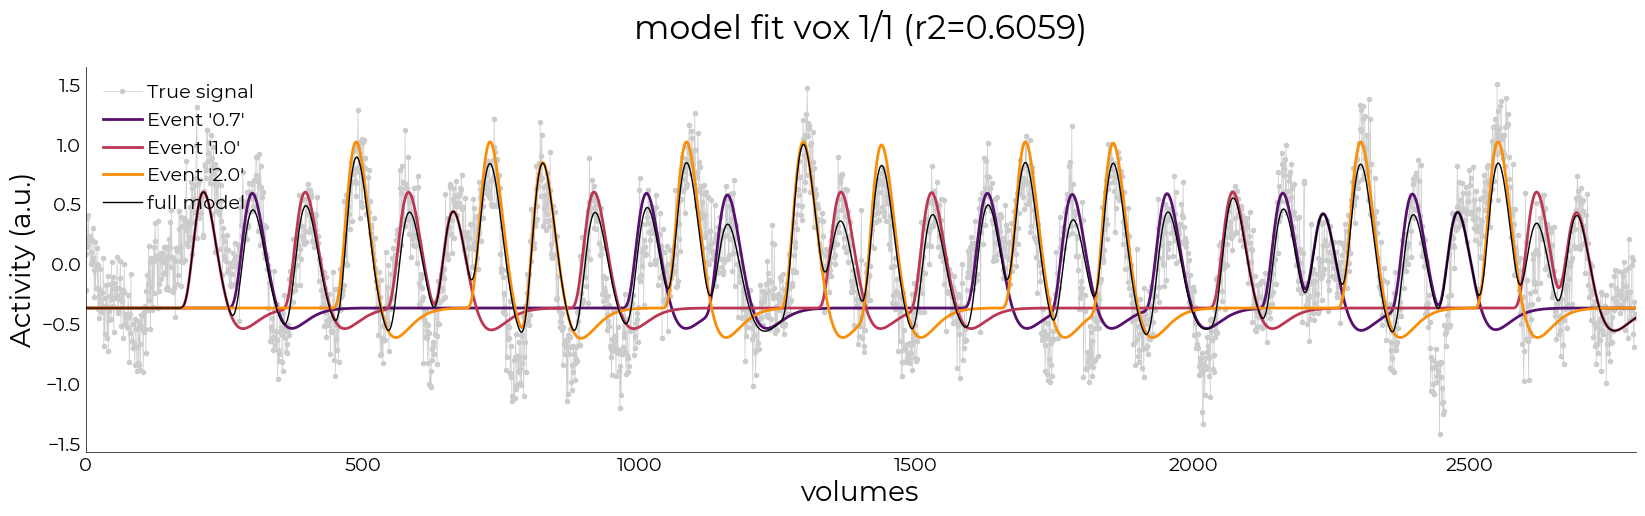

In [25]:
fitter.create_design(add_intercept=add_intercept)
fitter.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True,
    add_intercept=add_intercept,
    save_as=opj(fig_dir, f"{subject}_ses-{sesID}_desc-avg_ribbon_glm.pdf")
)
t_pre = fitter.results["tstats"]

### GLM - ribbon data

In [26]:
try:
    df_rib = utils.select_from_df(df_ribbon, expression="task = SRFa")
except:
    df_rib = df_ribbon.copy()
df_rib.head()

vox 357   vox 358   vox 359   vox 360   vox 361   vox 362  \
subject t                                                                   
006     0.000 -0.348059 -0.174502 -0.261333 -0.187846 -0.078641 -0.321503   
        0.105 -0.117662  0.010147  0.175145  0.097352  0.082867  0.367322   
        0.210  0.557093  0.370444  0.299833  0.297384  0.506386  0.087354   
        0.315  0.096745 -0.023221  0.131969  0.077520  0.082381  0.236375   
        0.420 -0.260572  0.004637  0.299712  0.098232  0.418100  0.122449   

                vox 363   vox 364   vox 365  
subject t                                    
006     0.000 -0.255746 -0.091667 -0.254022  
        0.105  0.007149  0.033410  0.115039  
        0.210  0.220918  0.503985  0.645987  
        0.315  0.373377  0.113096  0.180969  
        0.420  0.089076  0.395259  0.344503

In [27]:
fit_rib = glm.GenericGLM(
    active_onsets, 
    df_rib,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True
)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0. 0. 0.]: [26.49291199 27.71423528 28.78250699 28.80802134 27.95850046 26.34361365
 26.40783764 26.38913976 26.8339    ]
t-stat [0. 0. 0. 1. 1. 0. 0.]: [29.65154407 31.78313659 33.12629904 32.51267515 31.794353   29.65493614
 31.60700539 31.45168845 32.40708802]
t-stat [0. 0. 0. 0. 0. 1. 1.]: [41.82867765 45.48158432 48.1549665  48.26339746 46.50091553 45.16578048
 45.69812742 45.80048114 46.80013056]


(3, 9)

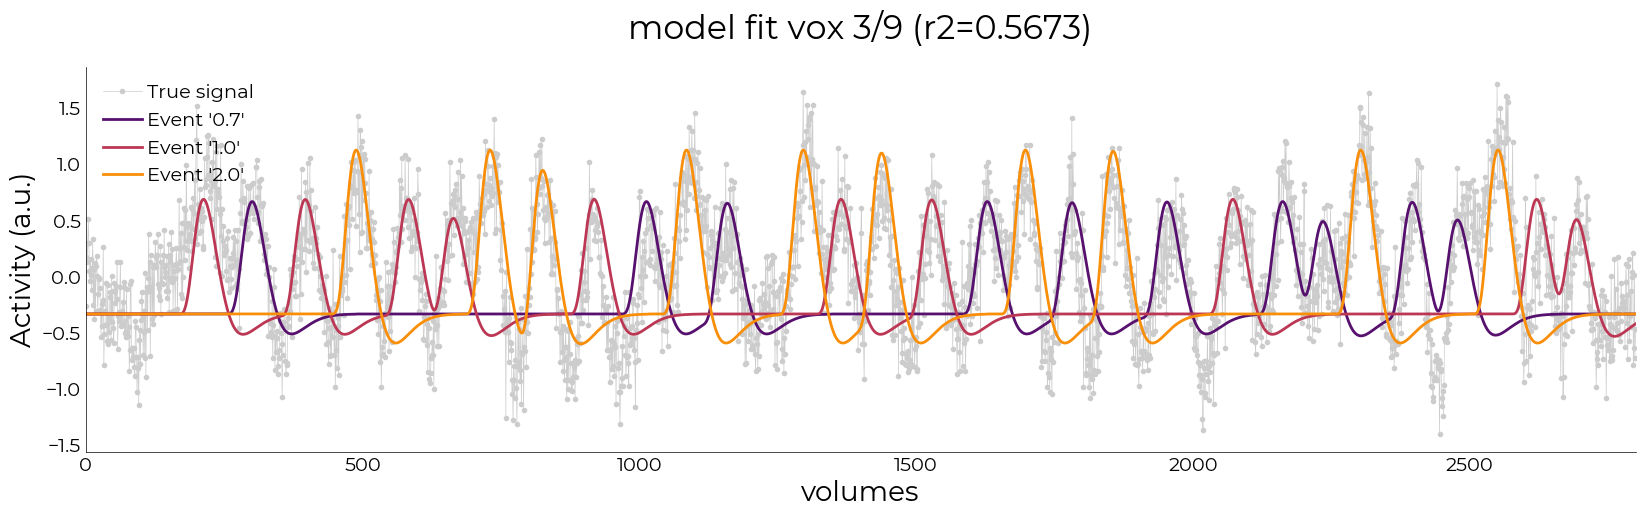

In [28]:
fit_rib.create_design(add_intercept=add_intercept)
fit_rib.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    add_intercept=add_intercept,
    # plot_full=True,
    save_as=opj(fig_dir, f"{subject}_ses-{sesID}_desc-ribbon_glm.pdf")
)

t_rib = fit_rib.results["tstats"]
t_rib.shape

In [29]:
ddict = {}
t_ = []
i_ = []
v_ = []
d_ = []
c_ = []
i_name = []
# for ix,tag in enumerate(["act","norm","full"]):
lbl = [str(round(float(i),2)) for i in evs]
for ix,tag in enumerate(lbl):
    t_.append(t_rib[ix,:])
    i_.append(np.full(t_rib.shape[1],ix))
    c_.append(np.full(t_rib.shape[1],str(tag), dtype=object))
    v_.append(np.arange(0,t_rib.shape[1]))
    d_.append([round(ii,2) for ii in np.arange(0,t_rib.shape[1])/(t_rib.shape[1]-1)*100])

ddict["tstat"] = np.concatenate(t_)
ddict["contrast_ix"] = np.concatenate(i_)
ddict["contrast"] = np.concatenate(c_)
ddict["voxel"] = np.concatenate(v_)
ddict["depth"] = np.concatenate(d_)

df_t = pd.DataFrame(ddict)
df_t.head()

tstat  contrast_ix contrast  voxel  depth
0  26.492912            0      0.7      0    0.0
1  27.714235            0      0.7      1   12.5
2  28.782507            0      0.7      2   25.0
3  28.808021            0      0.7      3   37.5
4  27.958500            0      0.7      4   50.0

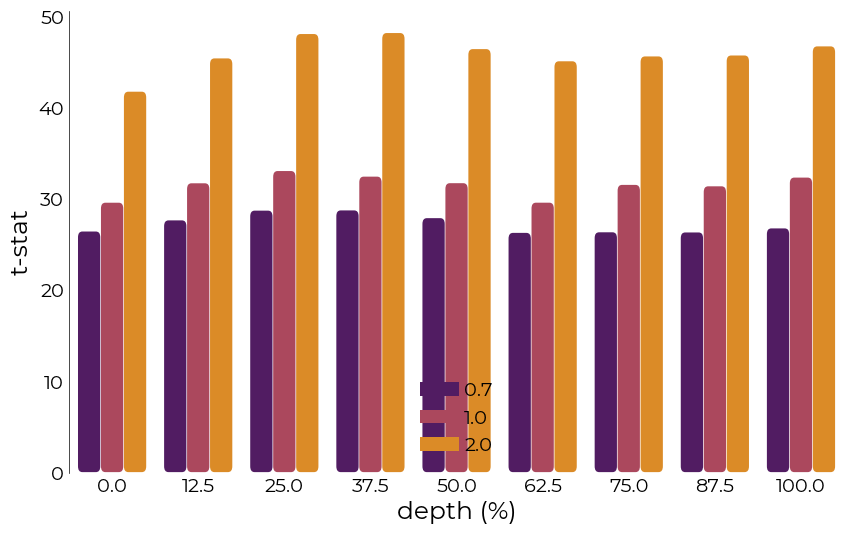

In [30]:
plotting.LazyBar(
    data=df_t,
    x="depth",
    y="tstat",
    hue="contrast",
    sns_ori="v",
    error=None,
    figsize=(10,6),
    fancy=True,
    fancy_rounding=0.05,
    fancy_denom=4,
    add_labels=True,
    x_label="depth (%)",
    y_label="t-stat",
    bar_legend=True,
    save_as=opj(fig_dir, f"{subject}_ses-{sesID}_desc-ribbon_bar.pdf")
)

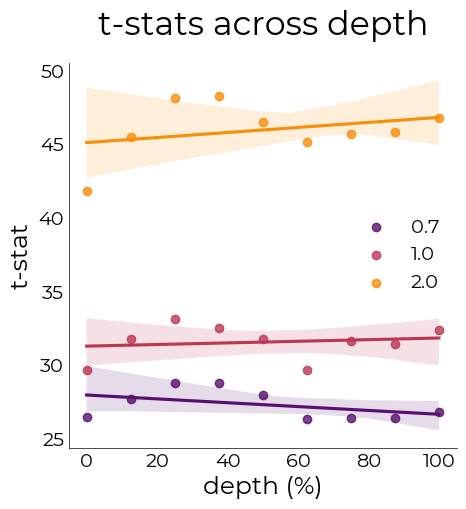

In [31]:
import seaborn as sns
fig,axs = plt.subplots(figsize=(5,5))

colors = sns.color_palette("inferno", len(lbl))
for ix,tag in enumerate(lbl):
    pl = plotting.LazyCorr(
        d_[ix],
        t_rib[ix,:],
        axs=axs,
        color=colors[ix],
        label=tag,
        x_label="depth (%)",
        y_label="t-stat",
        title="t-stats across depth",
)

axs.legend(frameon=False, fontsize=pl.label_size)

# fname = opj(fig_dir, f"{subject}_ses-{sesID}_desc-ribbon_scatter")
# for ext in ["pdf"]:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
    # )

### GLM - full line

In [32]:
try:
    df_avg_filt = df_filt.groupby(["subject","task","t"]).mean()
    df_line = utils.select_from_df(df_avg_filt, expression=f"task = SRFa")
except:
    df_line = df_filt.groupby(["subject", "t"]).mean()
df_line.head()

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject t                                                                   
006     0.000  2.731110  1.041266  4.391026  3.384549 -2.334087  1.819319   
        0.105 -4.455280  4.535692  3.155602 -1.902888  5.565221  2.174586   
        0.210 -7.249962  4.652827 -0.166988 -4.288532 -2.772521 -1.573341   
        0.315 -1.950892  9.378112 -1.068757  2.416934 -1.458533 -1.938920   
        0.420 -3.211707  4.927329 -4.199953 -3.863338  3.129756  1.279321   

                  vox 6     vox 7     vox 8     vox 9  ...   vox 710  \
subject t                                              ...             
006     0.000  1.098042 -5.044601  4.316827  5.410799  ...  0.222239   
        0.105 -0.379611  1.218950 -6.518507 -7.460359  ... -4.902647   
        0.210  3.775982 -4.603889 -0.838296  3.337891  ... -2.263630   
        0.315 -4.206816  2.039252  0.021005  1.618465  ...  0.312243   
        0.420 -6.954492 -0.636297 -3.080374 -1.164672  ...  9.624645   

                 vox 711    vox 712    vox 713    vox 714    vox 715  \
subject t                                                              
006     0.000   1.978724   9.267819   2.178664   8.466355  -6.781345   
        0.105  -6.696449   8.740315   8.523236  -5.712302   1.694762   
        0.210 -11.962929 -19.797182  -4.994963 -10.517043 -11.158431   
        0.315  -4.776294  18.515165  14.393773   0.908928  11.713722   
        0.420   4.031077  -5.493673 -18.451349 -14.068367   4.690853   

                vox 716    vox 717    vox 718   vox 719  
subject t                                                
006     0.000  9.276390   1.011536  -0.302532 -7.489326  
        0.105 -0.658908 -16.728930  -0.885465  3.782299  
        0.210 -3.711304  -2.344921  12.482837  8.105353  
        0.315 -0.260187   1.306632   9.312261  2.131026  
        0.420 -0.454615   4.827869  -8.043587 -6.367509  

[5 rows x 720 columns]

In [33]:
fit_line = glm.GenericGLM(
    active_onsets, 
    df_line,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True,
    add_intercept=add_intercept
)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


(3, 720)

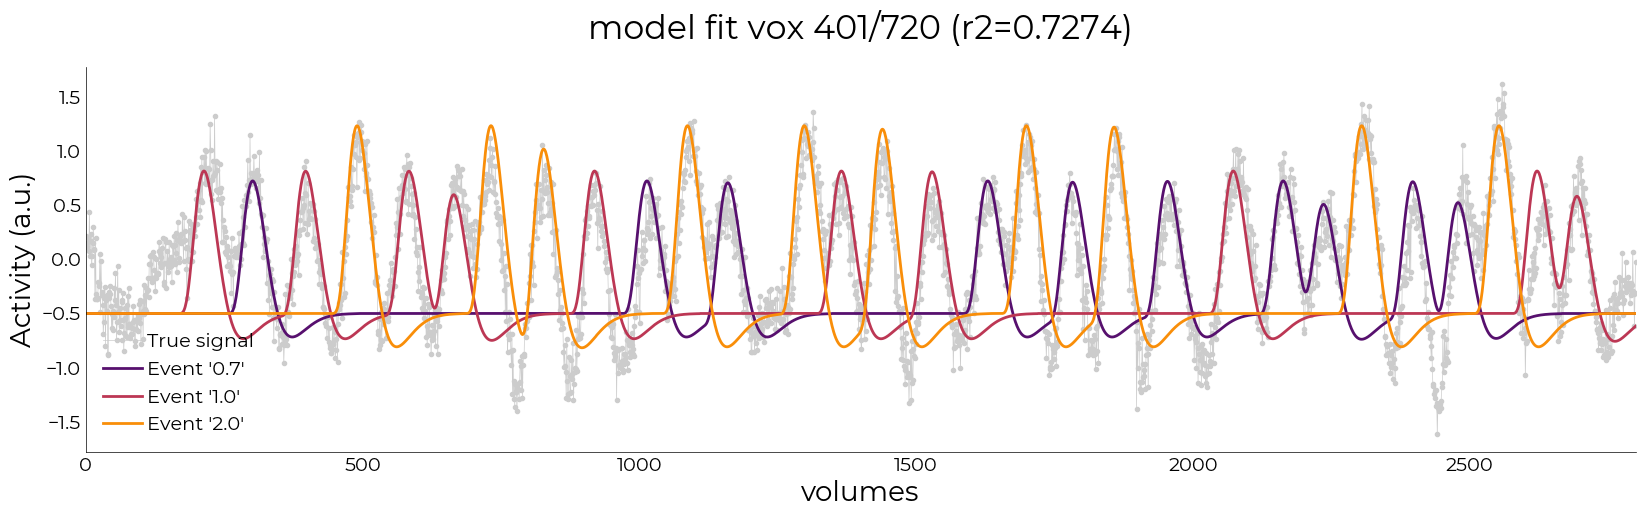

In [34]:
fit_line.create_design(add_intercept=add_intercept)
fit_line.fit(
    make_figure=True, 
    copes=c_vec, 
    add_intercept=add_intercept,
    # verbose=True, 
    # plot_full=True,
    save_as=opj(fig_dir, f"{subject}_ses-{sesID}_desc-best_from_line.pdf")
)

t_line = fit_line.results["tstats"]
t_line.shape

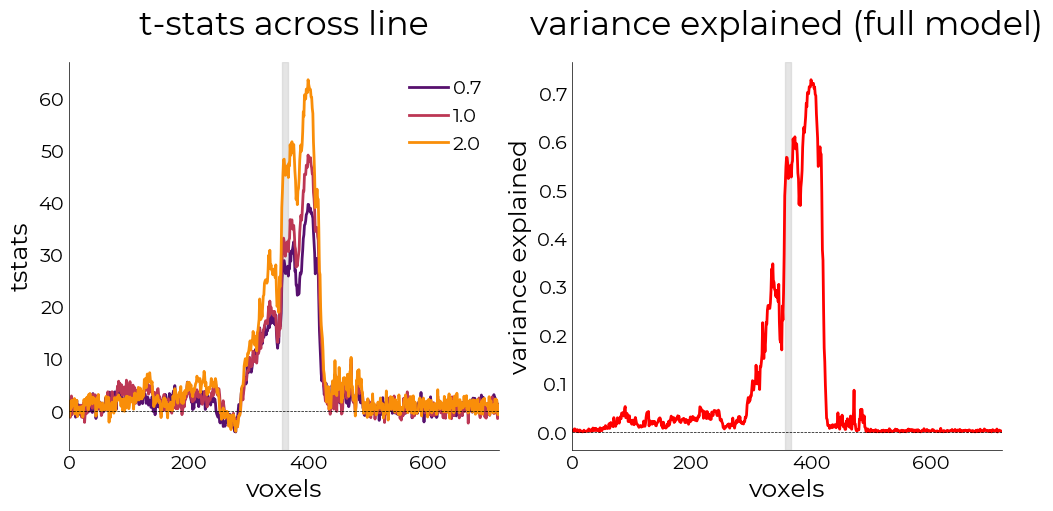

In [35]:
fig,axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
plotting.LazyPlot(
    [t_line[i] for i,_ in enumerate(fit_line.plot_event)],
    axs=axs[0],
    x_label="voxels",
    y_label="tstats",
    labels=fit_line.plot_event,
    line_width=2,
    cmap="inferno",
    add_hline=0,
    title="t-stats across line"
)

plotting.LazyPlot(
    fit_line.results["r2"],
    axs=axs[1],
    x_label="voxels",
    y_label="variance explained",
    line_width=2,
    color="r",
    title="variance explained (full model)",
    add_hline=0
)

for ax in axs:
    ax.axvspan(*ribbon, alpha=0.5, color="#cccccc")

fname = opj(fig_dir, f"{subject}_ses-{sesID}_desc-line_distribution")
for ext in ["pdf"]:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )    

In [36]:
# slice_file = opj(
#     os.environ.get("DIR_DATA_HOME"), 
#     subject, 
#     "ses-2", 
#     "anat", 
#     f"{subject}_ses-2_task-SRFa_run-1_acq-1slice_T1w.nii.gz")

# stats_file = opj(
#     os.environ.get("DIR_DATA_DERIV"), 
#     "feat", 
#     "level2", 
#     f"{subject}_desc-level1.gfeat", 
#     "cope1.feat", 
#     "stats", 
#     "tstat1_space-line.nii.gz")

# beam_file = opj(
#     os.environ.get("DIR_DATA_HOME"), 
#     subject, 
#     "ses-2", 
#     "func", 
#     f"{subject}_ses-2_task-SRFa_run-1_bold.nii.gz")

# mask_file = opj(
#     os.path.dirname(stats_file),
#     "mask_space-line.nii.gz"
# )

# obj_ = hr.data.CorrelationPlotter(
#     slice_file=slice_file,
#     stats_file=stats_file,
#     beam_file=beam_file,
#     mask_file=mask_file,
#     line_stats=t_line[0]
# )

In [37]:
# fig,axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
# obj_.plot_images(axs=axs[0])
# obj_.plot_tstat_correlation(
#     axs=axs[1], 
#     correlation=True,
#     scatter_kwargs={
#         "alpha": 0.4,
#         "cmap": "seismic",
#         "label": "distance to target (mm)",
#         "vmin": -5,
#         "vmax": 5}
#     )

In [38]:
# fname = opj(fig_dir, f"{subject}_ses-2_desc-corr_3d_line")
# for ext in ["pdf"]:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )    

## Deconvolve

In [39]:
try:
    active_onsets = utils.select_from_df(renamed_onsets, expression=("run = 1","&","event_type != response"))
except:
    active_onsets = renamed_onsets

try:
    df_rib = utils.select_from_df(df_ribbon, expression="task = SRFa")
except:
    df_rib = df_ribbon.copy()

df_rib2 = df_rib.copy().reset_index()
df_rib2["run"] = 1
df_rib2 = df_rib2.set_index(["subject","run", "t"])
df_rib2.head()

vox 357   vox 358   vox 359   vox 360   vox 361   vox 362  \
subject run t                                                                   
006     1   0.000 -0.348059 -0.174502 -0.261333 -0.187846 -0.078641 -0.321503   
            0.105 -0.117662  0.010147  0.175145  0.097352  0.082867  0.367322   
            0.210  0.557093  0.370444  0.299833  0.297384  0.506386  0.087354   
            0.315  0.096745 -0.023221  0.131969  0.077520  0.082381  0.236375   
            0.420 -0.260572  0.004637  0.299712  0.098232  0.418100  0.122449   

                    vox 363   vox 364   vox 365  
subject run t                                    
006     1   0.000 -0.255746 -0.091667 -0.254022  
            0.105  0.007149  0.033410  0.115039  
            0.210  0.220918  0.503985  0.645987  
            0.315  0.373377  0.113096  0.180969  
            0.420  0.089076  0.395259  0.344503

In [40]:
active_onsets.tail()

onset
subject run event_type            
006     1   0.7         246.479622
            0.7         254.979630
            2.0         263.062914
            1.0         270.371209
            1.0         277.921122

In [142]:
# fit events on averaged data
can_fit = fitting.NideconvFitter(
    df_rib2,
    active_onsets, 
    basis_sets='canonical_hrf_with_time_derivative_dispersion',
    # n_regressors=4,
    TR=0.105,
    interval=[-3,25],
    verbose=True,
    # conf_intercept=True,
    add_intercept=True,
    fit=True
)
can_fit.timecourses_condition()

# fit events on averaged data
fou_fit = fitting.NideconvFitter(
    df_rib2,
    active_onsets, 
    basis_sets='fir',
    n_regressors="tr",
    TR=0.105,
    interval=[-3,25],
    verbose=True,
    fit=True,
    add_intercept=True,
)


Converting dtype of onsets to int64...


Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event '0.7' to model
Adding event '1.0' to model
Adding event '2.0' to model
Fitting with 'ols' minimization
Done


Converting dtype of onsets to int64...


Selected 'fir'-basis sets (with 267 regressors)
Adding event '0.7' to model
Adding event '1.0' to model
Adding event '2.0' to model
Fitting with 'ols' minimization
Done


In [144]:
# # fit button response on single run data
# response_onsets = utils.select_from_df(df_onsets, expression="event_type = response")
# fit_button = fitting.NideconvFitter(
#     df_func,
#     response_onsets,
#     basis_sets='fourier',
#     n_regressors=9,
#     TR=0.105,
#     interval=[-3,17],
#     add_intercept=True,
#     verbose=True,
#     fit=True)

# fit_button.timecourses_condition()

## Plotting

### Average over ribbon voxels

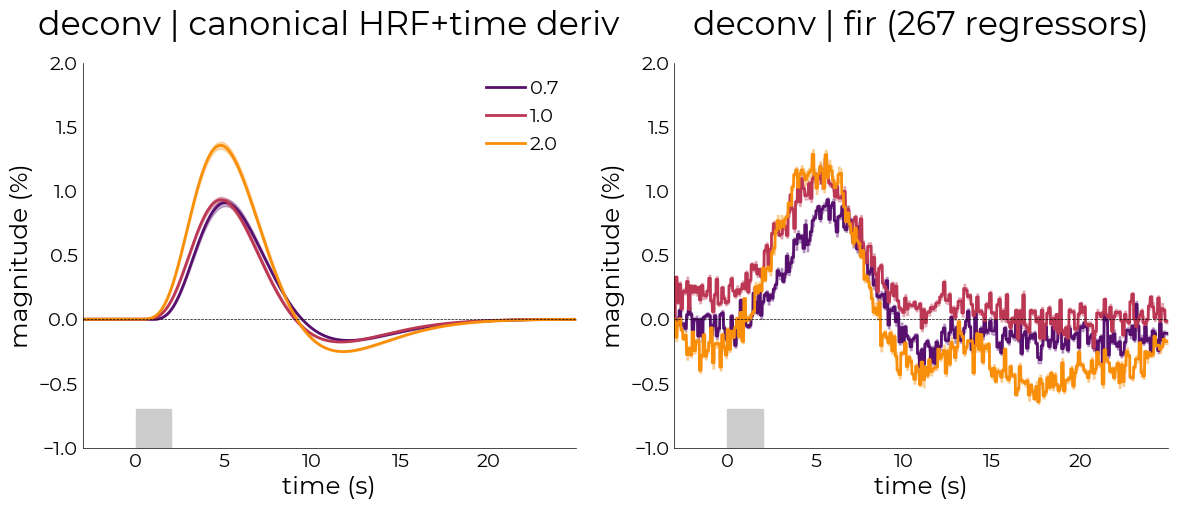

In [145]:
%matplotlib inline
fig,axs = plt.subplots(ncols=2, figsize=(14,5))

y_lim = [-1,2]
can_fit.plot_average_per_event(
    x_label="time (s)",
    add_offset=False,
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[0],
    title="deconv | canonical HRF+time deriv",
    labels=[round(float(i),2) for i in can_fit.cond],
    line_width=2,
    cmap='inferno',
    fancy=True,
    # ttp=True,
    y_lim=y_lim)

fou_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[1],
    title=f"deconv | {fou_fit.basis_sets} ({fou_fit.n_regressors} regressors)",
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

# plot stimulus onset
for ax in axs:
    ax.axvspan(0,2, ymax=0.1, color="#cccccc")

In [146]:
# # individual model fits
# fit_objs = []
# for ii in can_fit.cond:

#     nd_ = fitting.NideconvFitter(
#         df_rib2,
#         utils.select_from_df(df_onsets, expression=f"event_type = {ii}"),
#         basis_sets='canonical_hrf_with_time_derivative',
#         TR=0.105,
#         interval=[-3,25],
#         add_intercept=True,
#         verbose=True)

#     nd_.timecourses_condition()
#     fit_objs.append(nd_)

In [147]:
# par_fit = fitting.ParameterFitter(
#     df_rib2,
#     active_onsets,
#     TR=0.105
# )

# deconv_kw={
#     "interval": [0,25],
#     "osf": 100,
#     "resample_to_shape": 5320,
#     "n_jobs": df_rib2.shape[-1]
# }

# par_fit.fit(**deconv_kw)

In [148]:
depth = np.linspace(0,100,num=can_fit.tc_condition.shape[-1])
depth

array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ])

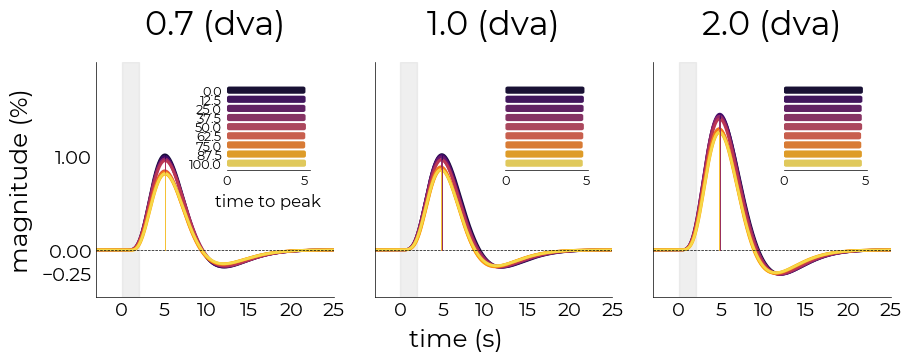

In [149]:
fig,axs = plt.subplots(
    ncols=len(can_fit.cond), 
    figsize=(len(can_fit.cond)*3,3.5), 
    gridspec_kw={"wspace": 0.1}, 
    sharey=True, 
    constrained_layout=True
)

for ix,ev in enumerate(can_fit.cond):
    # if ix+1 == len(can_fit.cond):
    # if ix == 0:
    #     lbl = [f"{round(i,2)}%" for i in depth]
    # else:
    lbl = None
        
    df = utils.select_from_df(can_fit.tc_condition, expression=f"event_type = {ev}")
    ev_prof = list(df.values.T)
    pl = plotting.LazyPlot(
        ev_prof,
        xx=df.index.get_level_values("time").values,
        line_width=2,
        axs=axs[ix],
        title=f"{round(float(ev),2)} (dva)",
        add_hline=0,
        x_ticks=[0,5,10,15,20,25],
        y_ticks=[-0.25,0,1],
        labels=lbl,
        cmap="inferno",
        y_lim=[-0.5,2]
        # legend_kwargs={"fontsize": 11}
    )

    axs[ix].axvspan(0,2, ymax=1, alpha=0.3, color="#cccccc")

    if ix == 0:
        lbl = [str(round(float(i),2)) for i in depth]
        x_lbl = "time to peak"
        add_lbl = True
    else:
        lbl = None
        x_lbl = None
        add_lbl = False

    left,bottom,width,height = 0.55,0.55,0.35,0.35
    ax2 = axs[ix].inset_axes([left, bottom, width, height])
    can_fit.plot_ttp(
        df,
        axs=ax2,
        hrf_axs=pl.axs,
        ttp_lines=True,
        font_size=pl.font_size/1.5,
        label_size=pl.label_size/1.5,
        fancy=True,
        sns_offset=1.5,
        add_labels=add_lbl,
        ttp_labels=lbl,
        x_label=x_lbl
    )

    # can_fit.plot_fwhm(
    #     df,
    #     axs=ax2,
    #     hrf_axs=axs[ix],
    #     fwhm_lines=True,
    #     font_size=pl.font_size/1.5,
    #     label_size=pl.label_size/1.5,
    #     fancy=True,
    #     sns_offset=1.5,
    #     add_labels=add_lbl,
    #     fwhm_labels=lbl,
    #     x_label=x_lbl
    # )    

fig.supxlabel("time (s)", fontsize=pl.font_size)
fig.supylabel("magnitude (%)", fontsize=pl.font_size)
fig.show()

In [153]:
interval = [-3,25]
TR = 0.105

can_avg = fitting.NideconvFitter(
    hp_data,
    active_onsets, 
    basis_sets='canonical_hrf_with_time_derivative_dispersion',
    TR=TR,
    # fit_type="ridge",
    interval=interval,
    verbose=True,
    # conf_intercept=True,
    fit=True,
    add_intercept=True
)
can_avg.timecourses_condition()

can_avg_ridge = fitting.NideconvFitter(
    hp_data,
    active_onsets, 
    basis_sets=can_avg.basis_sets, #_dispersion',
    TR=TR,
    fit_type="ridge",
    interval=interval,
    verbose=True,
    add_intercept=True,
    fit=True
)
can_avg_ridge.timecourses_condition()

# dct_avg = fitting.NideconvFitter(
#     hp_data,
#     active_onsets, 
#     basis_sets='dct',
#     # fit_type="ridge",
#     n_regressors=11,
#     TR=TR,
#     interval=interval,
#     verbose=True,
#     fit=True
# )
# dct_avg.timecourses_condition()

# # dct_avg_ridge = fitting.NideconvFitter(
# #     hp_data,
# #     active_onsets, 
# #     basis_sets='dct',
# #     fit_type="ridge",
# #     n_regressors=11,
# #     TR=TR,
# #     interval=interval,
# #     conf_intercept=False,
# #     verbose=True,
# #     fit=True
# # )
# # dct_avg_ridge.timecourses_condition()

# fir_avg = fitting.NideconvFitter(
#     hp_data,
#     active_onsets, 
#     basis_sets='fir',
#     fit_type="ridge",
#     n_regressors="tr",
#     TR=TR,
#     interval=interval,
#     add_intercept=False,
#     conf_intercept=False,
#     verbose=True,
#     fit=True)
# fir_avg.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event '0.7' to model
Adding event '1.0' to model
Adding event '2.0' to model
Fitting with 'ols' minimization
Done


Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Setting up models ridge-regression
Fitting with 'ridge' minimization
Done


In [154]:
def get_full_model_prediction(
    obj, 
    time=None,
    data=None,
    profiles=None,
    make_figure=False, 
    title=None,
    correct_offset=False,
    lp_kwargs={},
    **kwargs):
    
    if isinstance(obj, fitting.NideconvFitter):
        preds = obj.ev_predictions.copy()

        # construct design matrix from predictors
        X = preds.unstack('event_type').values
        
        profiles = list(obj.tc_condition.unstack(["event_type"]).values.T)
        data = obj.func.values.squeeze()
        time = np.unique((obj.tc_condition.index.get_level_values("time")))
        full_model_prediction = obj.predictions.copy().values
    else:
        preds = obj
        
        # construct design matrix from predictors
        X = preds.unstack('event_type').values

        # get betas
        beta = np.ones([X.shape[-1],1])
        full_model_prediction = X.dot(beta).squeeze()

    if make_figure:
        fig,(ax1,ax2,ax3) = plt.subplots(
            ncols=3, 
            gridspec_kw={"width_ratios": [0.15,0.2,0.5]}, 
            figsize=(16,4), 
            constrained_layout=True)
        
        sns.heatmap(X, ax=ax1)
        
        # low pass?
        if len(lp_kwargs) > 0:
            print("im here")
            profiles = [preproc.lowpass_savgol(i, **lp_kwargs) for i in profiles]

        if correct_offset:
            prof_list = []
            for i in profiles:
                if i[0] < 0:
                    i += abs(i[0])
                else:
                    i -= i[0]
                
                prof_list.append(i)
        else:
            prof_list = profiles

        pl = plotting.LazyPlot(
            prof_list,
            xx=time,
            axs=ax2,
            line_width=2,
            add_hline=0,
            title="HRFs",
            y_label="volumes",
            x_label="time (s)",
            cmap="inferno",
            **kwargs
        )

        # conform heatmap to plotting standards
        plotting.conform_ax_to_obj(ax1, obj=pl, x_label="regressors", y_label="volumes")

        data_list = list(preds.unstack(["event_type"]).values.T)
        plotting.LazyPlot(
            [data]+data_list+[full_model_prediction],
            color=["#cccccc"]+sns.color_palette("inferno", len(data_list))+["g"],
            markers=["."]+[None for _ in range(len(data_list)+1)],
            line_width=[0.5]+[2 for _ in range(len(data_list)+1)],
            # figsize=(7,7),
            axs=ax3,
            title="predictions",
            x_label="volumes",
            **kwargs
        )

        if isinstance(title, str):
            fig.suptitle(title, fontsize=pl.title_size+(pl.title_size*0.2))

    return full_model_prediction

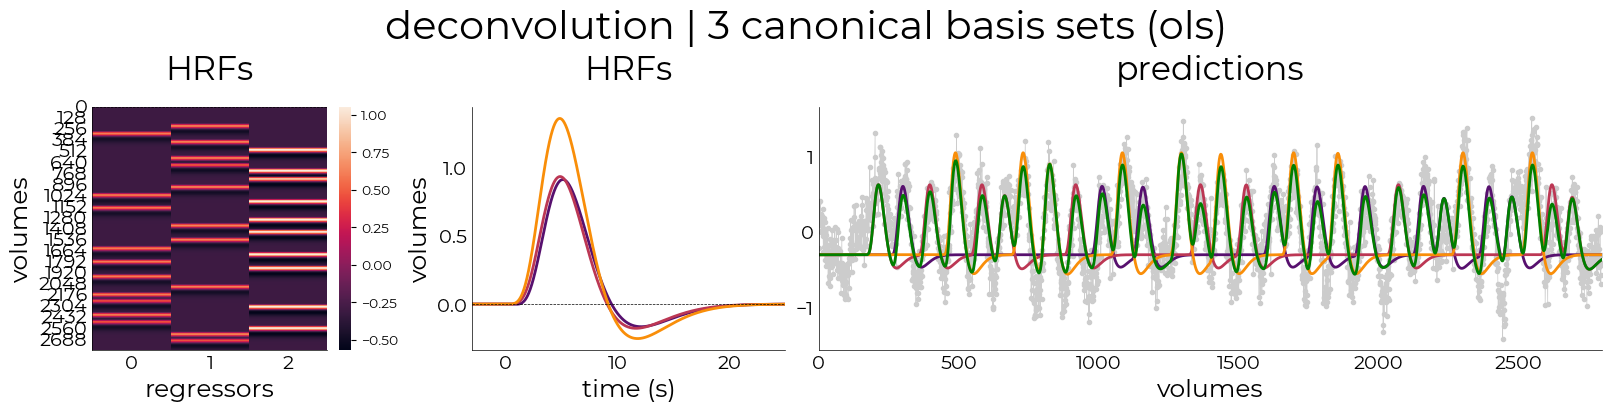

In [155]:
fm_ols = get_full_model_prediction(can_avg, make_figure=True, title=f"deconvolution | {can_avg.n_regressors} canonical basis sets ({can_avg.fit_type})")

AttributeError: 'NideconvFitter' object has no attribute 'predictions'

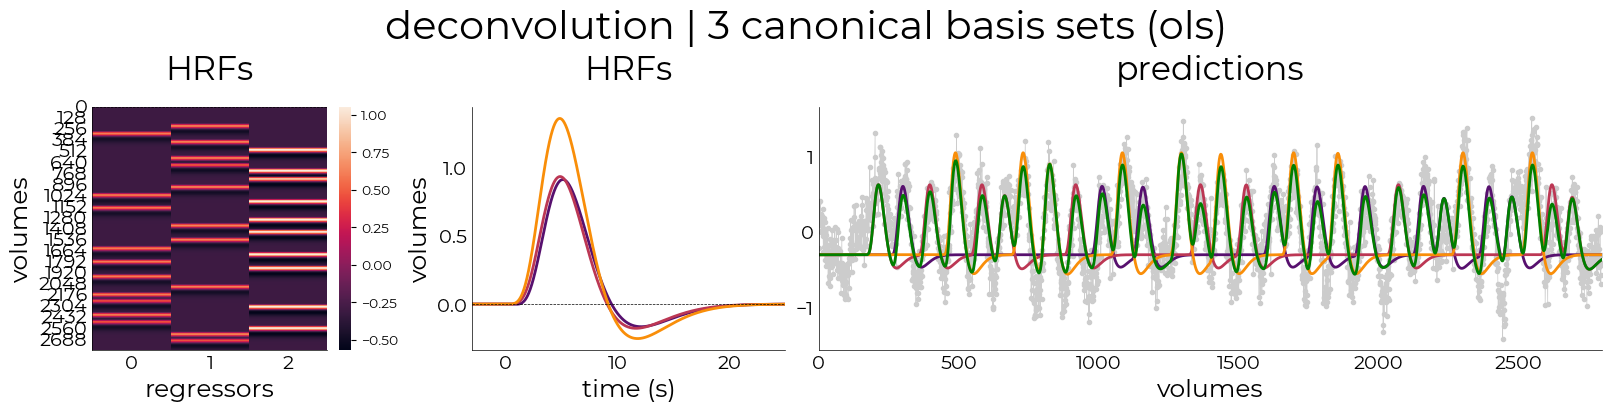

In [156]:
fm_ols = get_full_model_prediction(can_avg, make_figure=True, title=f"deconvolution | {can_avg.n_regressors} canonical basis sets ({can_avg.fit_type})")

fm_ridge = get_full_model_prediction(can_avg_ridge, make_figure=True, title=f"deconvolution | {can_avg.n_regressors} canonical basis sets ({can_avg_ridge.fit_type})")

im here


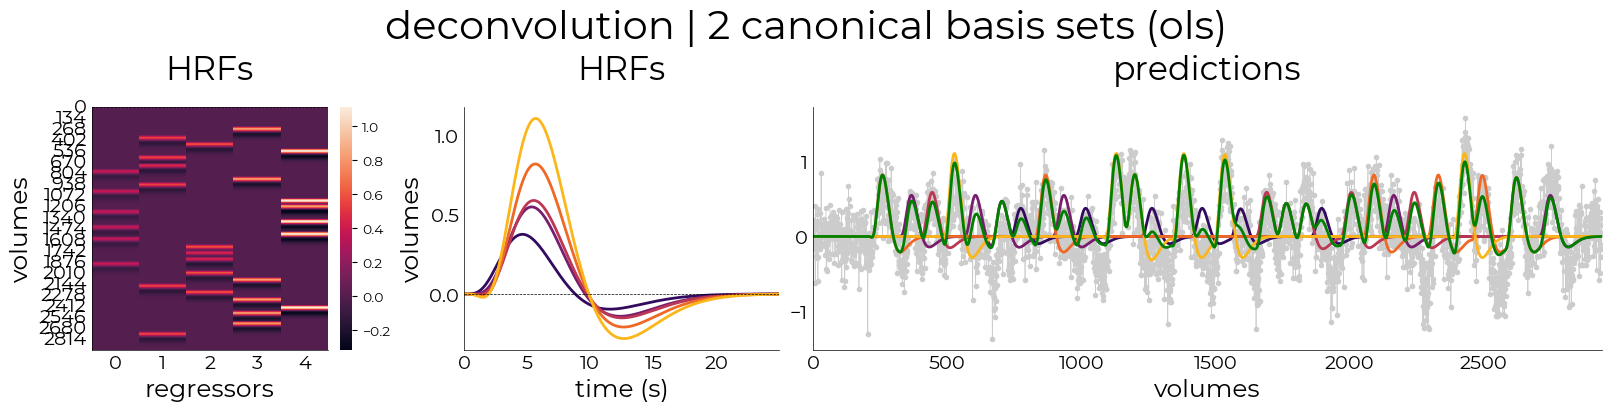

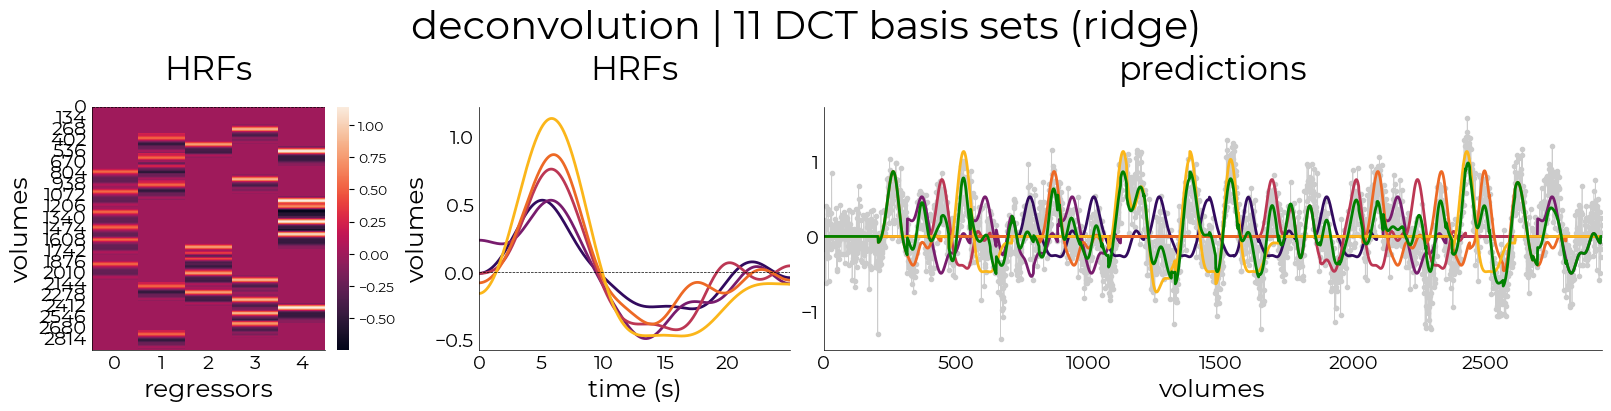

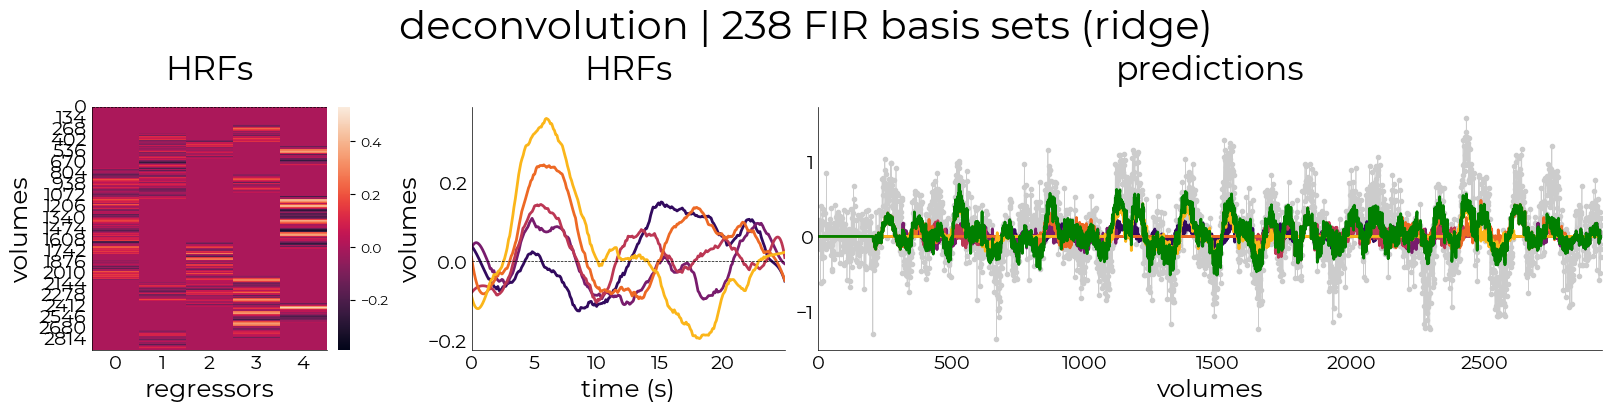

In [430]:
# fm_fit = get_full_model_prediction(
#     pd.concat(ev_pred).set_index(["event_type","run","t"]), 
#     time=np.unique((can_avg.tc_condition.index.get_level_values("time"))),
#     profiles=list(tc_condition.unstack(["event_type"]).values.T),
#     data=hp_data,
#     make_figure=True,
#     title="parameter optimization")

fm_can = get_full_model_prediction(can_avg, make_figure=True, title=f"deconvolution | {can_avg.n_regressors} canonical basis sets ({can_avg.fit_type})")
fm_dct = get_full_model_prediction(dct_avg, make_figure=True, title=f"deconvolution | {dct_avg.n_regressors} DCT basis sets ({dct_avg.fit_type})", correct_offset=False)
fm_fir = get_full_model_prediction(fir_avg, make_figure=True, title=f"deconvolution | {fir_avg.n_regressors} FIR basis sets ({fir_avg.fit_type})", lp_kwargs={"window_length": 501, "polyorder": 3}, correct_offset=False)

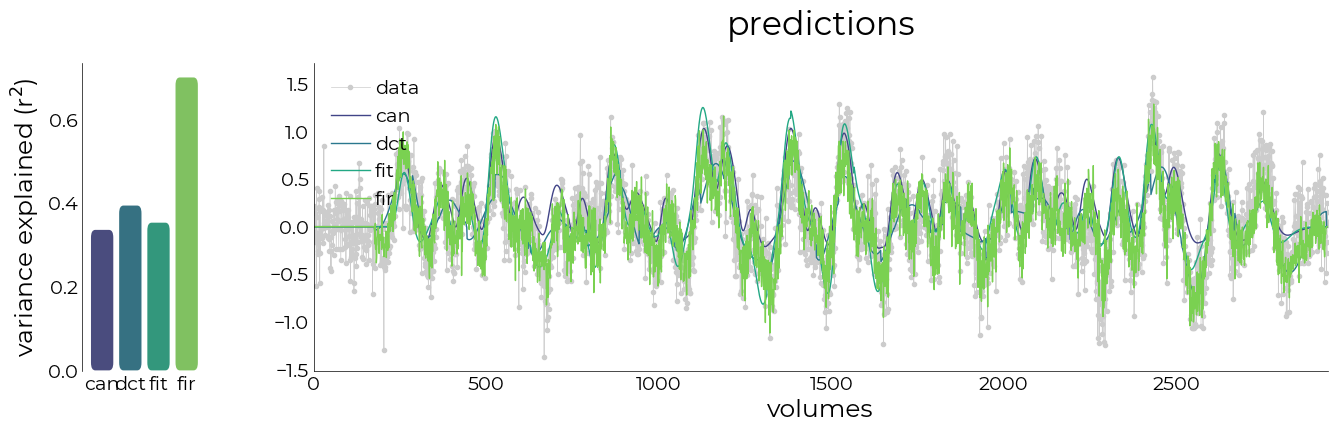

In [418]:
from sklearn import metrics
all_models = {
    "can": fm_can,
    "dct": fm_dct,
    "fit": fm_fit,
    "fir": fm_fir
}

r2 = []
for _,f in all_models.items():
    r2.append(metrics.r2_score(hp_data,f))
    
r2 = np.array(r2)
r2_d = pd.DataFrame({
    "r2": r2,
    "fit": np.array(list(all_models.keys())),
    "code": np.arange(0,len(all_models))
    }
)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(16,4), gridspec_kw={"width_ratios": [0.1,0.9]})
plotting.LazyBar(
    data=r2_d,
    x="fit",
    y="r2",
    axs=ax1,
    cmap="viridis",
    add_labels=True,
    y_label="variance explained (r$^2$)",
    sns_offset=4,
    fancy=True,
    fancy_denom=6
)

plotting.LazyPlot(
    [hp_data]+[i for _,i in all_models.items()],
    color=["#cccccc"]+sns.color_palette("viridis", len(all_models)),
    markers=["."]+[None for _ in range(len(all_models))],
    line_width=[0.5]+[1 for _ in range(len(all_models))],
    axs=ax2,
    title="predictions",
    x_label="volumes",
    labels=["data"]+[i for i,_ in all_models.items()]
)

In [240]:
df_pars = []
for ix,ev in enumerate(can_fit.cond):
    pars = fitting.HRFMetrics(utils.select_from_df(can_fit.tc_condition, expression=f"event_type = {ev}")).return_metrics()
    pars["sizes"] = ev
    pars["depth"] = depth
    df_pars.append(pars)
df_pars = pd.concat(df_pars, ignore_index=False)
df_pars.head()

magnitude  magnitude_ix      fwhm  time_to_peak  half_rise_time  half_max  \
0   1.009271          1537  4.463539       5.06925        2.996354  0.504635   
0   0.998306          1539  4.464366       5.07975        3.004992  0.499153   
0   0.971017          1537  4.463481       5.06925        2.995776  0.485509   
0   0.964918          1539  4.464602       5.07975        3.007581  0.482459   
0   0.972431          1546  4.467056       5.11650        3.041178  0.486216   

   rise_slope  rise_slope_t sizes  depth  
0    0.396306       3.00600   0.7    0.0  
0    0.391813       3.01650   0.7   12.5  
0    0.381298       3.00600   0.7   25.0  
0    0.378657       3.02175   0.7   37.5  
0    0.381049       3.05325   0.7   50.0

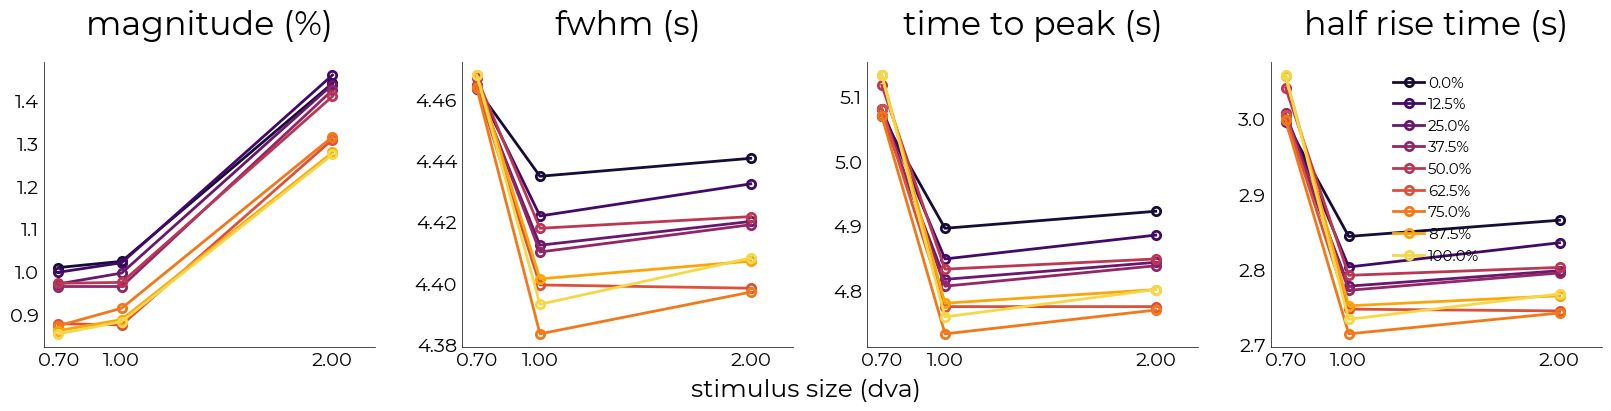

In [241]:
from holeresponse import viz
stim_pars = viz.PlotStimPars(df=df_pars)
stim_pars.plot_metrics_across_stims(
    fig_kwargs={"gridspec_kw": {"wspace": 0.1}},
    legend_kwargs={"fontsize": 11},
    plot_kw={
        "markerfacecolor": "none",
        "markeredgewidth": 2
    }
)

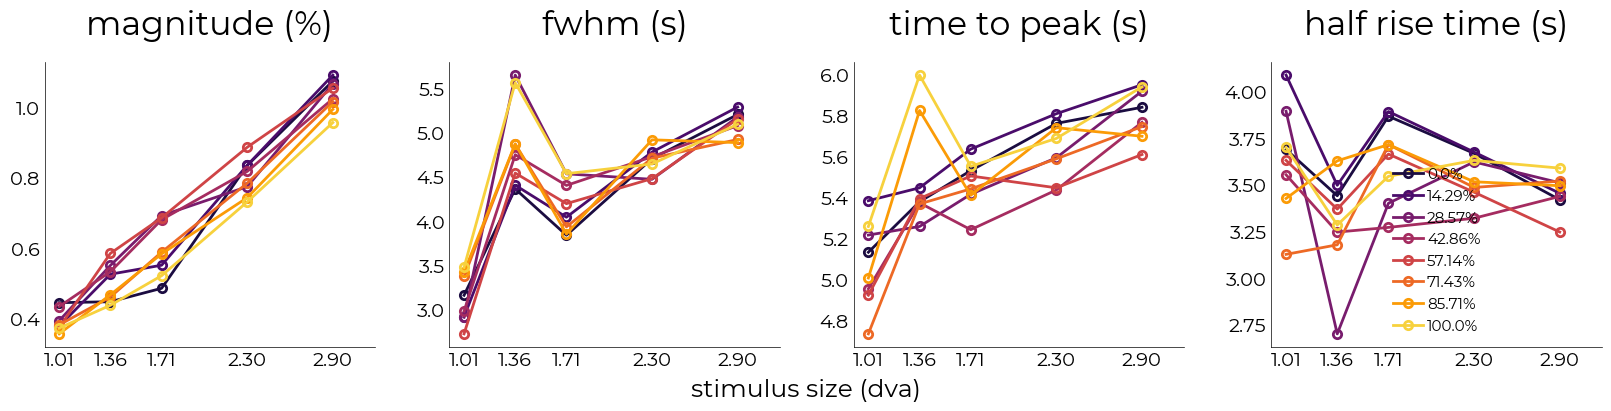

In [ ]:
from holeresponse import viz
stim_pars = viz.PlotStimPars(df=df_pars)
stim_pars.plot_metrics_across_stims(
    fig_kwargs={"gridspec_kw": {"wspace": 0.1}},
    legend_kwargs={"fontsize": 11},
    plot_kw={
        "markerfacecolor": "none",
        "markeredgewidth": 2
    }
)

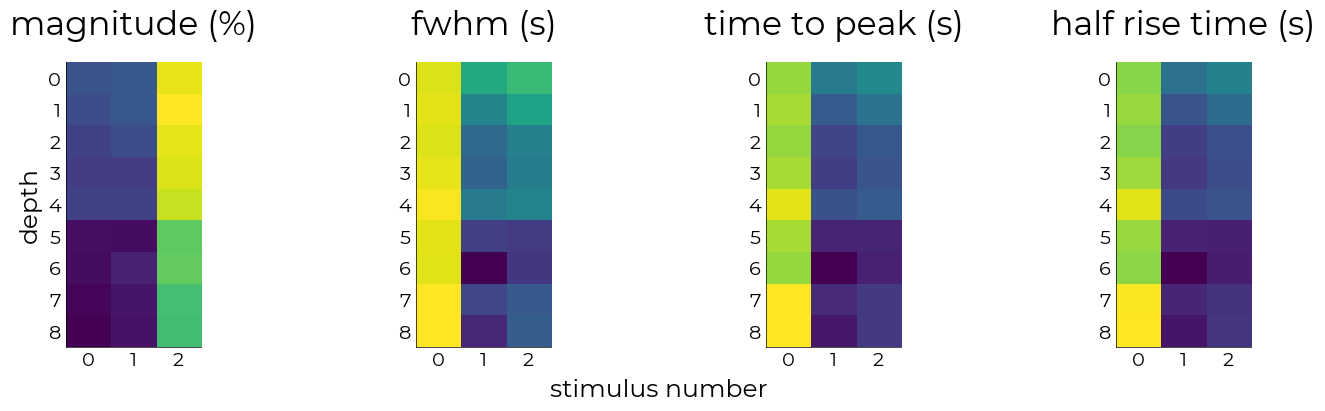

In [218]:
stim_pars.imshow_metrics_across_stims(aspect=0.7)

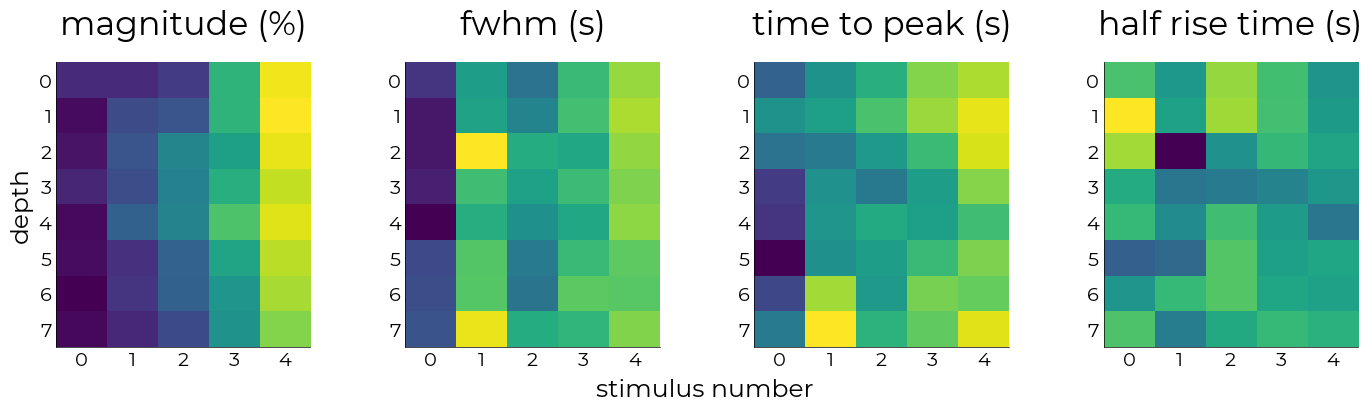

In [ ]:
stim_pars.imshow_metrics_across_stims(aspect=0.7)

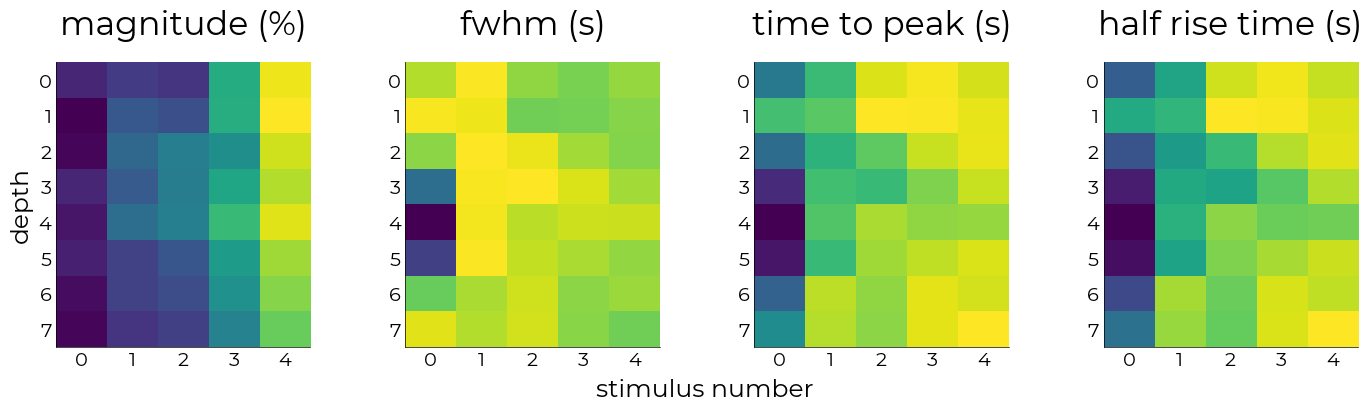

In [ ]:
stim_pars.imshow_metrics_across_stims(aspect=0.7)

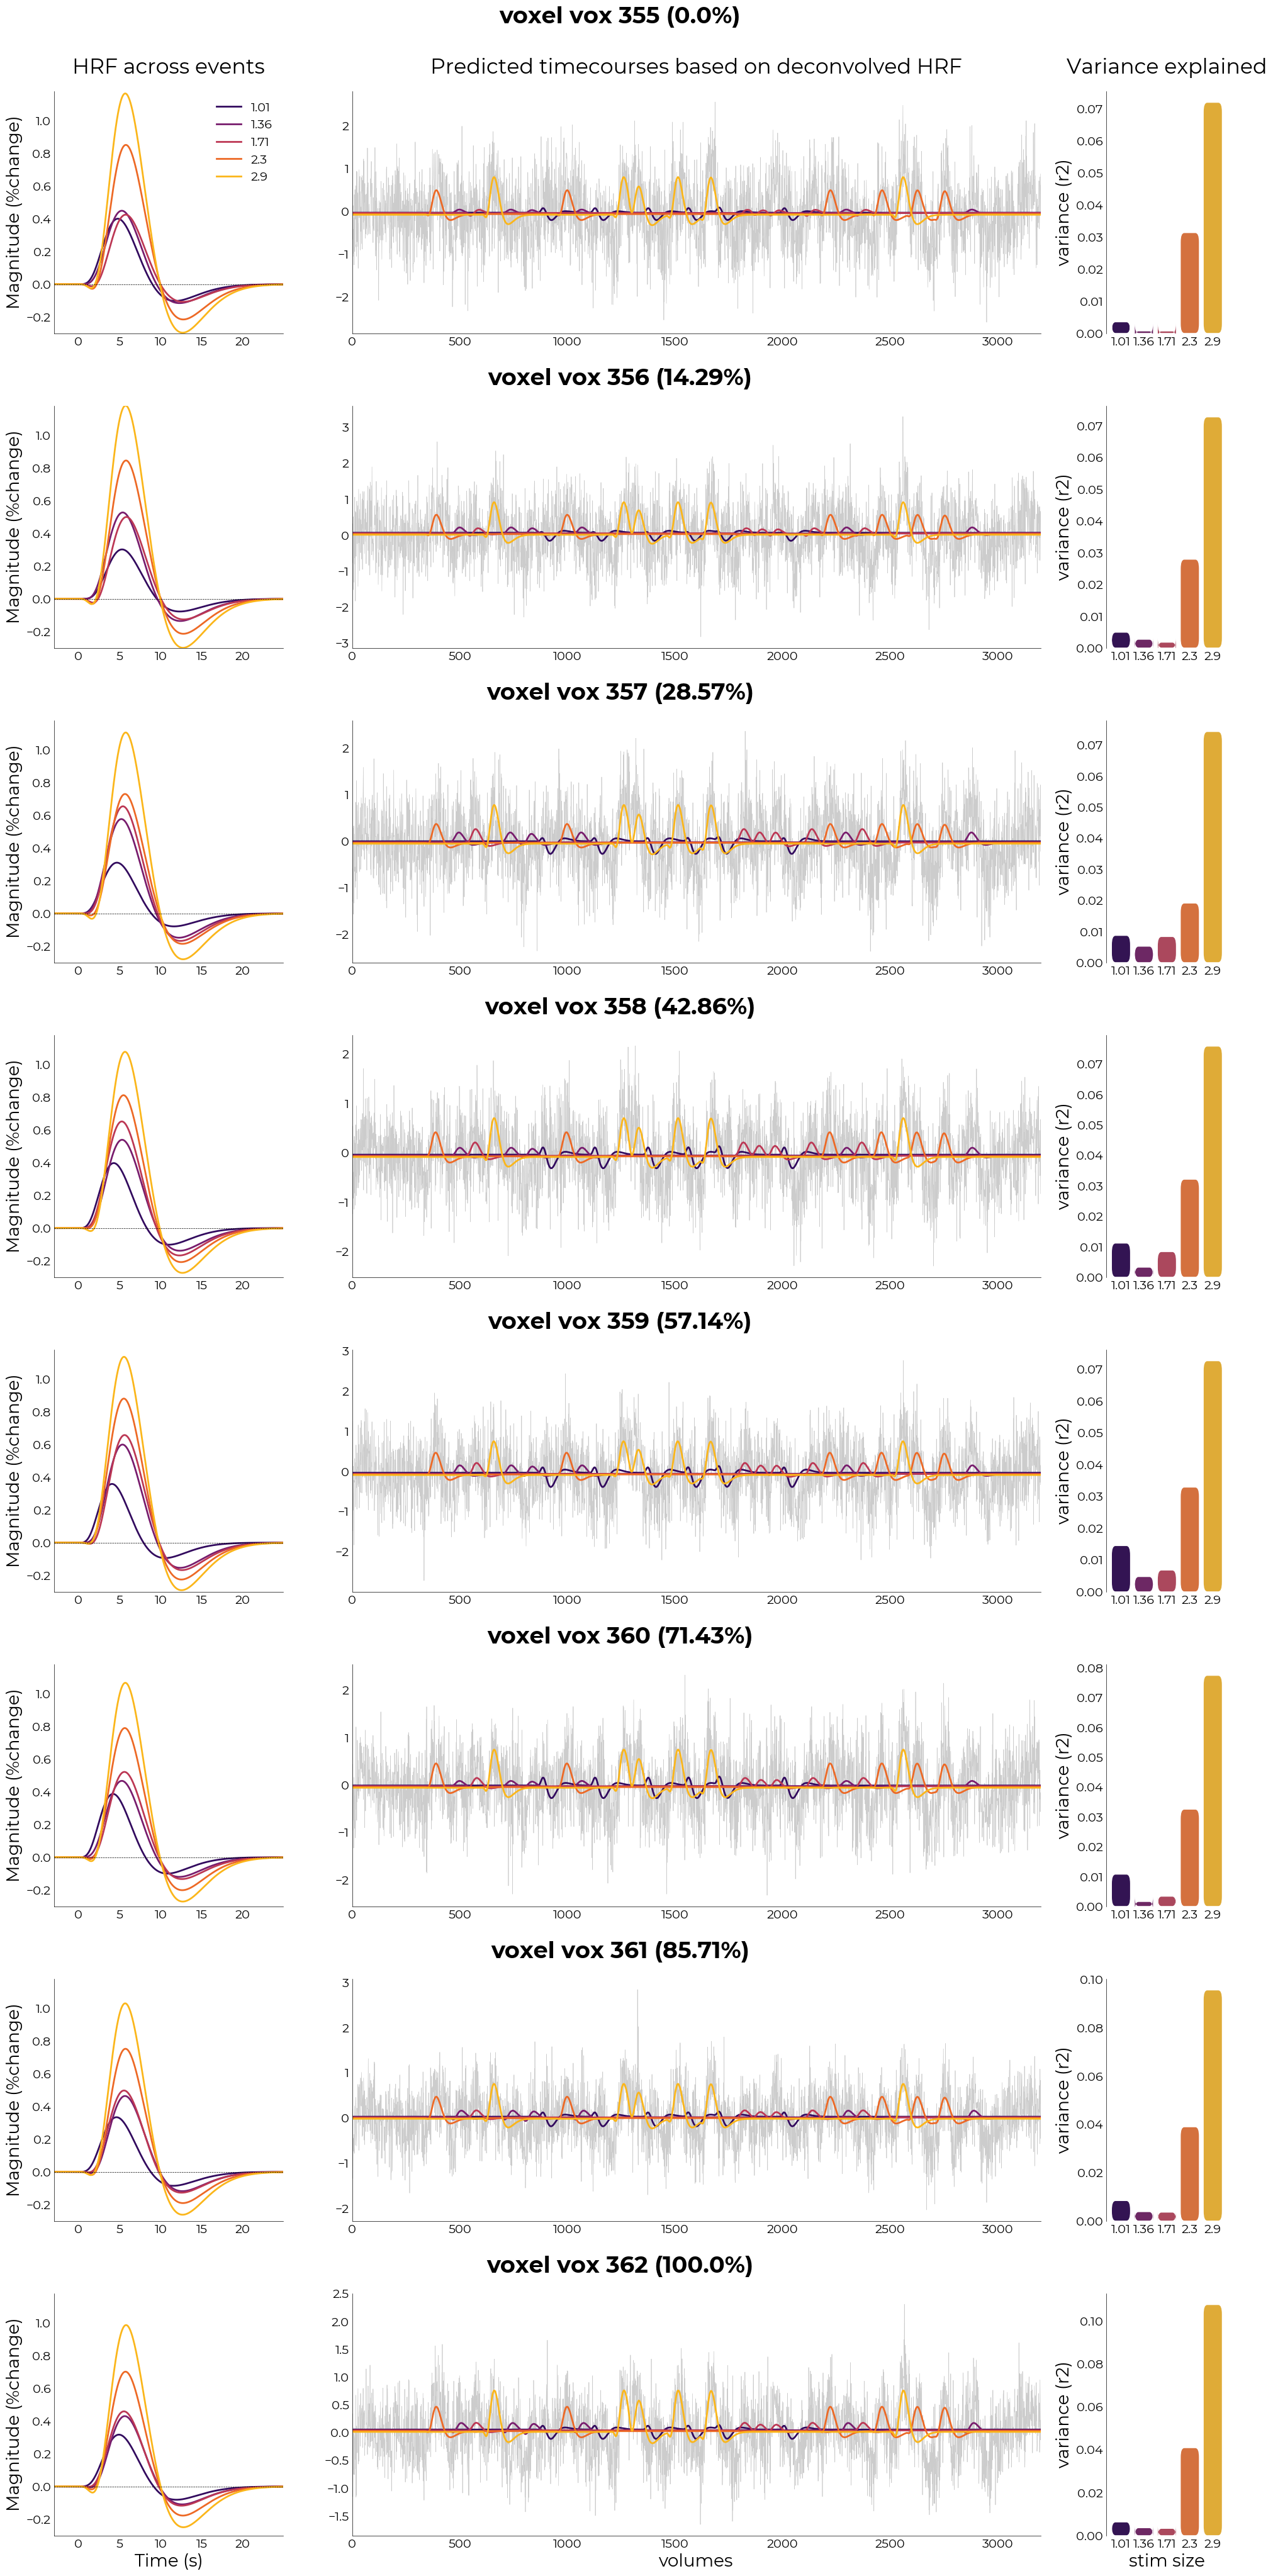

In [ ]:
from sklearn.metrics import r2_score

vox = list(df_rib2.columns)
fig = plt.figure(figsize=(24,5*len(vox)))
sf = fig.subfigures(nrows=len(vox))

font_size = 20
hrf_ax = []
for ix,el in enumerate(vox):
    axs = sf[ix].subplots(
        ncols=3, 
        gridspec_kw={
            "width_ratios": [1,3,.5],
            "wspace": 0.2
        }
    )

    ax1_title = None
    ax2_title = None
    ax3_title = None
    if ix == 0:
        ax1_title = "Average HRF across events"
        ax2_title = "Predicted timecourses based on deconvolved HRF"
        ax3_title = "Variance explained"

    x_lbl1 = None
    x_lbl2 = None
    x_lbl3 = None
    if ix == len(vox)-1:
        x_lbl1 = "time (s)"
        x_lbl2 = "volumes"
        x_lbl3 = "stim size"

    hrf_ax.append(axs[0])
    # fit_objs[ix].plot_average_per_event(
    #     axs=ax1,
    #     x_label=x_lbl1,
    #     y_label="Magnitude (%)",
    #     add_hline='default',
    #     ttp=True,
    #     title=ax1_title,
    #     ttp_lines=True,
    #     add_labels=True,
    #     ttp_labels=lbl,
    #     lim=[0, 6],
    #     ticks=[0,3,6],
    #     cmap='inferno',
    #     fancy=True,
    #     font_size=font_size)

    ax2 = axs[1]
    colors = sns.color_palette('inferno', len(can_fit.cond))
    preds = [utils.select_from_df(fit_objs[ii].predictions, expression="run = 1").iloc[:,ix].values for ii in range(len(fit_objs))]
    real = utils.select_from_df(df_rib2, expression="run = 1").iloc[:, ix].values

    plotting.LazyPlot(
        [ii for ii in [real]+preds],
        line_width=[0.5]+[2 for ii in range(len(fit_objs))],
        color=["#cccccc"]+colors,
        axs=ax2,
        title=ax2_title,
        font_size=font_size,
        x_label=x_lbl2)

    # calculate r2's
    ax3 = axs[2]
    r2s = [r2_score(real, preds[ii]) for ii in range(len(fit_objs))]
    pl = plotting.LazyBar(
        x=can_fit.cond,
        y=r2s,
        palette=colors,
        sns_ori="v",
        axs=ax3,
        add_labels=True,
        labels=lbl,
        x_label=x_lbl3,
        y_label="variance (r2)",
        font_size=font_size,
        title=ax3_title,
        fancy_denom=4,
        sns_offset=4,
        error=None,
        fancy=True)
    
    if ix == 0:
        y = 1.15
    else:
        y = 1

    sf[ix].suptitle(f"voxel {el} ({round(depth[ix],2)}%)", fontsize=pl.title_size+(pl.title_size*0.1), y=y, fontweight="bold")

can_fit.plot_average_per_voxel(
    labels=lbl,
    fig_kwargs={
        "wspace": 0.2,
        "hspace": 0.25
    },
    cmap="inferno",
    line_width=2,
    font_size=font_size,
    # label_size=16,
    axs=hrf_ax,
    title=["HRF across events",None,None,None,None,None,None,None],
    skip_x=[True,True,True,True,True,True,True,False],
    sharey=True)


In [ ]:
can_fit.model.get_rsq()

vox 355   vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run                                                               
003     1    0.145141  0.145711  0.159134  0.183839  0.177298  0.168711   

              vox 361   vox 362  
subject run                      
003     1    0.204945  0.221124

In [ ]:
fou_fit.model.get_rsq()

vox 355   vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run                                                               
003     1    0.125953  0.128747  0.143228  0.144192  0.146092  0.130082   

              vox 361   vox 362  
subject run                      
003     1    0.164381  0.181412

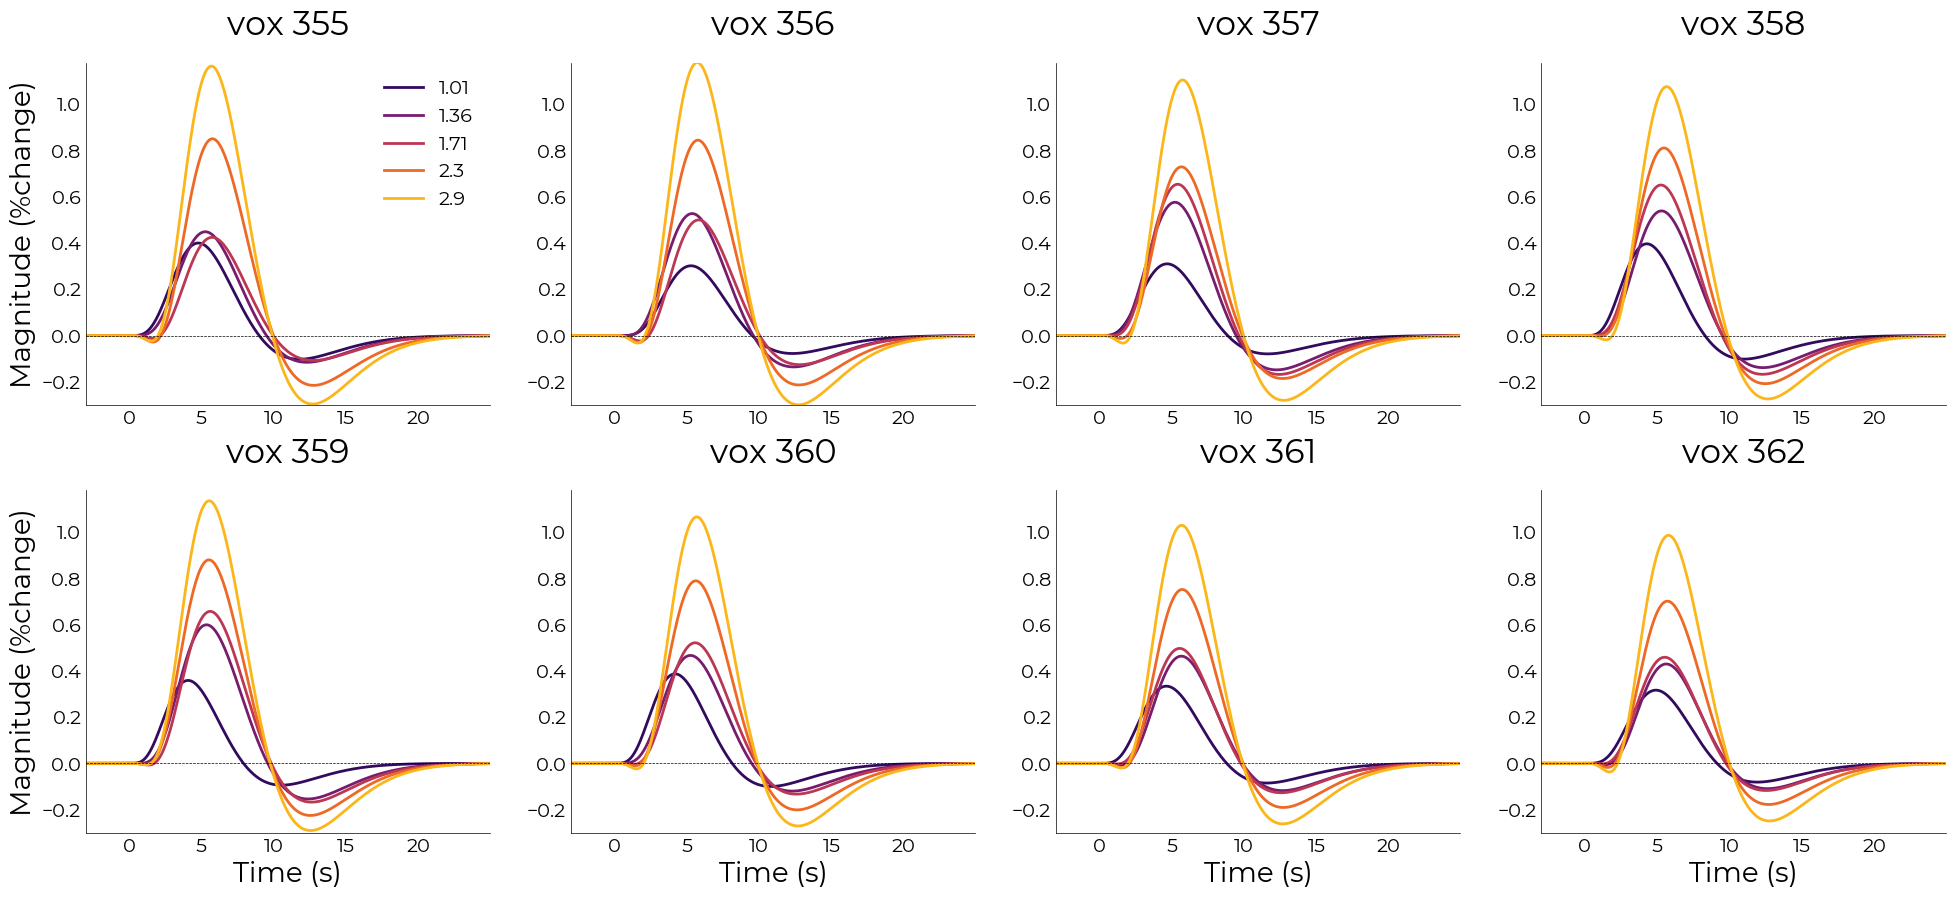

In [ ]:
can_fit.plot_average_per_voxel(
    labels=lbl,
    fig_kwargs={
        "wspace": 0.2,
        "hspace": 0.25
    },
    cmap="inferno",
    line_width=2,
    font_size=font_size,
    # label_size=16,
    sharey=True)


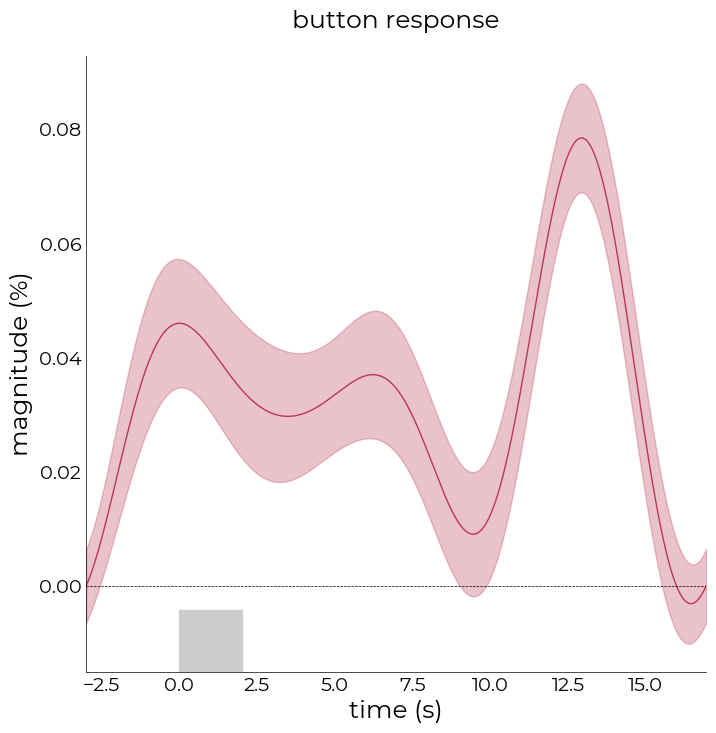

In [ ]:
# %matplotlib inline
# fig,axs = plt.subplots(figsize=(8,8))
# fit_button.plot_average_per_event(
#     x_label="time (s)",
#     y_label="magnitude (%)",
#     add_hline='default',
#     axs=axs,
#     title="button response",
#     add_labels=True,
#     fancy=True,
#     fancy_denom=6,
#     inset_ttp=[0.75, 0.8, 0.3],
#     cmap='inferno')

# # plot stimulus onset
# axs.axvspan(0,2, ymax=0.1, color="#cccccc")

### Split events over voxels

In [ ]:
df_ribbon.shape

(6400, 6)

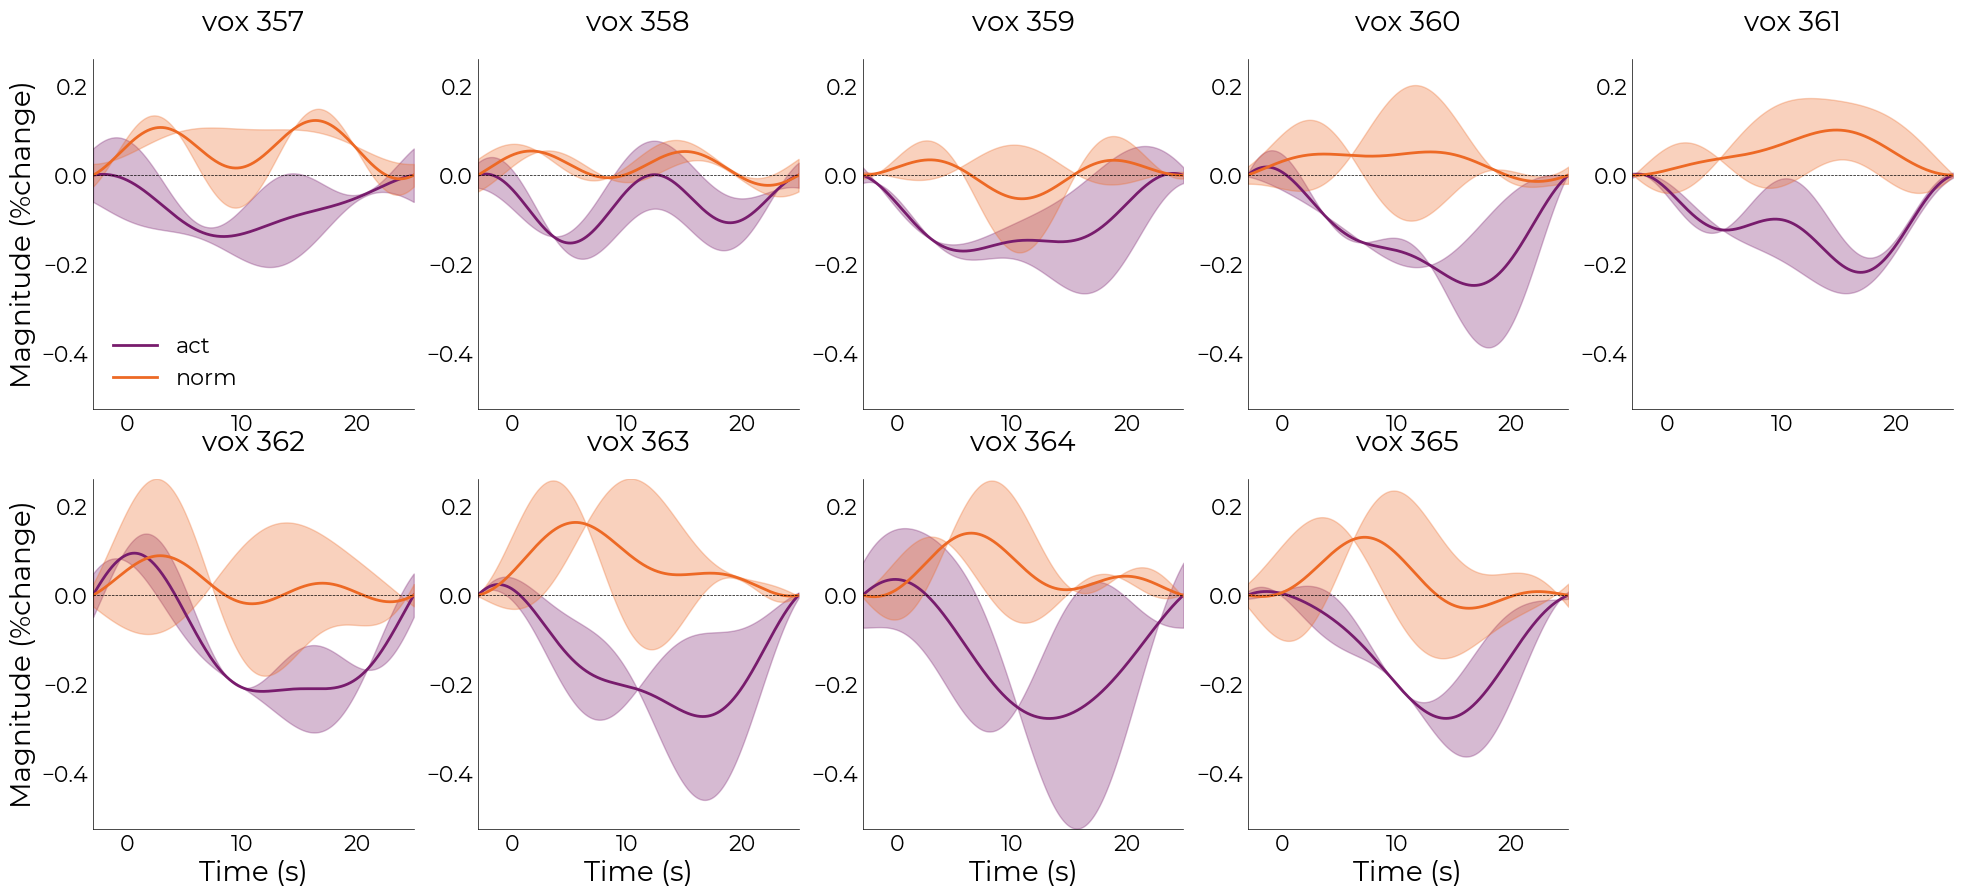

In [ ]:
fou_fit.plot_average_per_voxel(
    labels=can_fit.cond,
    wspace=0.2,
    # n_cols=df_ribbon.shape[-1],
    n_cols=5,
    cmap="inferno",
    line_width=2,
    font_size=20,
    label_size=16,
    sharey=True)
    # save_as=opj(func_dir, "hrf_gamma_voxel.png"))